<a href="https://colab.research.google.com/github/MatheusABomfim/Mest_MBL2_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading data and packages**

**Libraries import**

In [1]:
# Import necessary libraries and packages
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.inspection import permutation_importance

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,
    learning_curve
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, accuracy_score, roc_curve, auc, make_scorer,
    precision_score, f1_score
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,
    RobustScaler, StandardScaler
)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

# imbalanced-learn imports
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# joblib imports
from joblib import dump, load

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# openpyxl imports
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# ipywidgets imports
from ipywidgets import interact, widgets

# shap imports
import shap
from sklearn.inspection import permutation_importance

# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**Data import**

In [2]:
# Defining global variables to store the DataFrame and dataset name
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None

# Function to load and process the selected dataset
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Function to load and process the selected dataset
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Definindo X (features) e y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Function to define the selected balancing method
def set_balancing_method(method):
    global balancing_method_selected  # Declarando a variável como global
    balancing_method_selected = method  # Atribui o método selecionado à variável
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Function to apply the selected balancing method
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y


    X_res, y_res = balancer.fit_resample(X, y)
    #print(f"Balanceamento aplicado com sucesso usando: {balancing_method_selected}")
    return X_res, y_res

# Define the directory where the CSV files are located
directory = '../datasets/feature_selection/'

# List the CSV files available in the directory
csv_files = list_csv_files(directory)

# Create a selection widget with the files listed
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Create a widget to select the balancing method
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Interactive function to load and process the selected CSV file
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Interactive function to apply the selected balancing method
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")

interactive(children=(Dropdown(description='Select File:', options=('cat2_df_clinic_ENTPD1.csv',), value='cat2…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

In [3]:
# Translation of DF columns
column_translation = {
    'Gênero': 'Sex',
    'Idade_clinica': 'Age',
    'PROVAVEL_HAM/TSP': 'P-HAM/TSP',
    'Dermatológicos': 'Dermatological symptoms',
    'Artralgia': 'Arthralgia',
    'Comprometimento da função urinária': 'Urinary function impairment',
    'Sintomas psiquiátricos': 'Psychiatric symptoms',
    'Dor MMII': 'Lower limb pain',
    'Parestesia MMII': 'Lower limb paresthesia',
    'Paresia/Fraqueza MMII': 'Lower limb paresis weakness',
    'Dor Lombar/Coluna': 'Lower back spine pain',
    'Neuropatia MMSS': 'Upper limb neuropathy',
    'Função Motora': 'Motor function',
    'Expression_CD39_Diplotypes': 'CD39-Diplotypes'  # já em inglês
}

# Aplicar renomeação
df.rename(columns=column_translation, inplace=True)

# Exibir colunas renomeadas
print(df.columns)


Index(['Sex', 'Age', 'P-HAM/TSP', 'Urinary function impairment',
       'Lower limb pain', 'Lower limb paresthesia',
       'Lower limb paresis weakness', 'Upper limb neuropathy',
       'Motor function', 'CD39-Diplotypes'],
      dtype='object')


In [4]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '../models/'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Model {model_name} uploaded successfully.')
    else:
        print(f'File for model {model_name} not found.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)
definite_name = ['Decision Tree', 'Gradient Boosting', 'Logistic Regression', 'Multi-layer Perceptron', 'Naive Bayes', 'Random Forest', 'Support Vector Machine', 'K-Nearest Neighbors', 'AdaBoost', 'Linear SVM']


Model DT uploaded successfully.
Model GB uploaded successfully.
Model LR uploaded successfully.
Model MLP uploaded successfully.
Model NB uploaded successfully.
Model RF uploaded successfully.
Model SVM uploaded successfully.
Model KNN uploaded successfully.
Model AB uploaded successfully.
Model LSVM uploaded successfully.


In [5]:
print(df)

    Sex       Age  P-HAM/TSP  Urinary function impairment  Lower limb pain  \
0     1  0.606557          0                            0                0   
1     0  0.426230          0                            0                1   
2     0  0.721311          1                            0                1   
3     1  0.573770          0                            0                1   
4     0  0.786885          0                            0                1   
..  ...       ...        ...                          ...              ...   
93    0  0.688525          1                            0                0   
94    1  0.344262          1                            0                0   
95    1  0.672131          0                            0                0   
96    0  0.590164          0                            0                0   
97    0  0.049180          0                            0                0   

    Lower limb paresthesia  Lower limb paresis weakness  \
0   

In [5]:
# Instantiating RandomUnderSampler
rus = RandomUnderSampler()

# Apply RandomUnderSampler to data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame with the resampled data
df_ = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['PROVAVEL_HAM/TSP'])], axis=1)

# ...

y = df['P-HAM/TSP'] # Target variable as a NumPy array
X = df.drop('P-HAM/TSP', axis=1)  # Predictor variables as a NumPy array

In [6]:
# Find the index of the first value 1 (target)
first_one_index = np.where(y == 1)[0][0] if np.any(y == 1) else -1  
print(first_one_index)  

2


In [30]:
df.to_excel("data.xlsx", index=False)

# Waterfall

P-HAM/TSP

Importância das Características do modelo Decision Tree


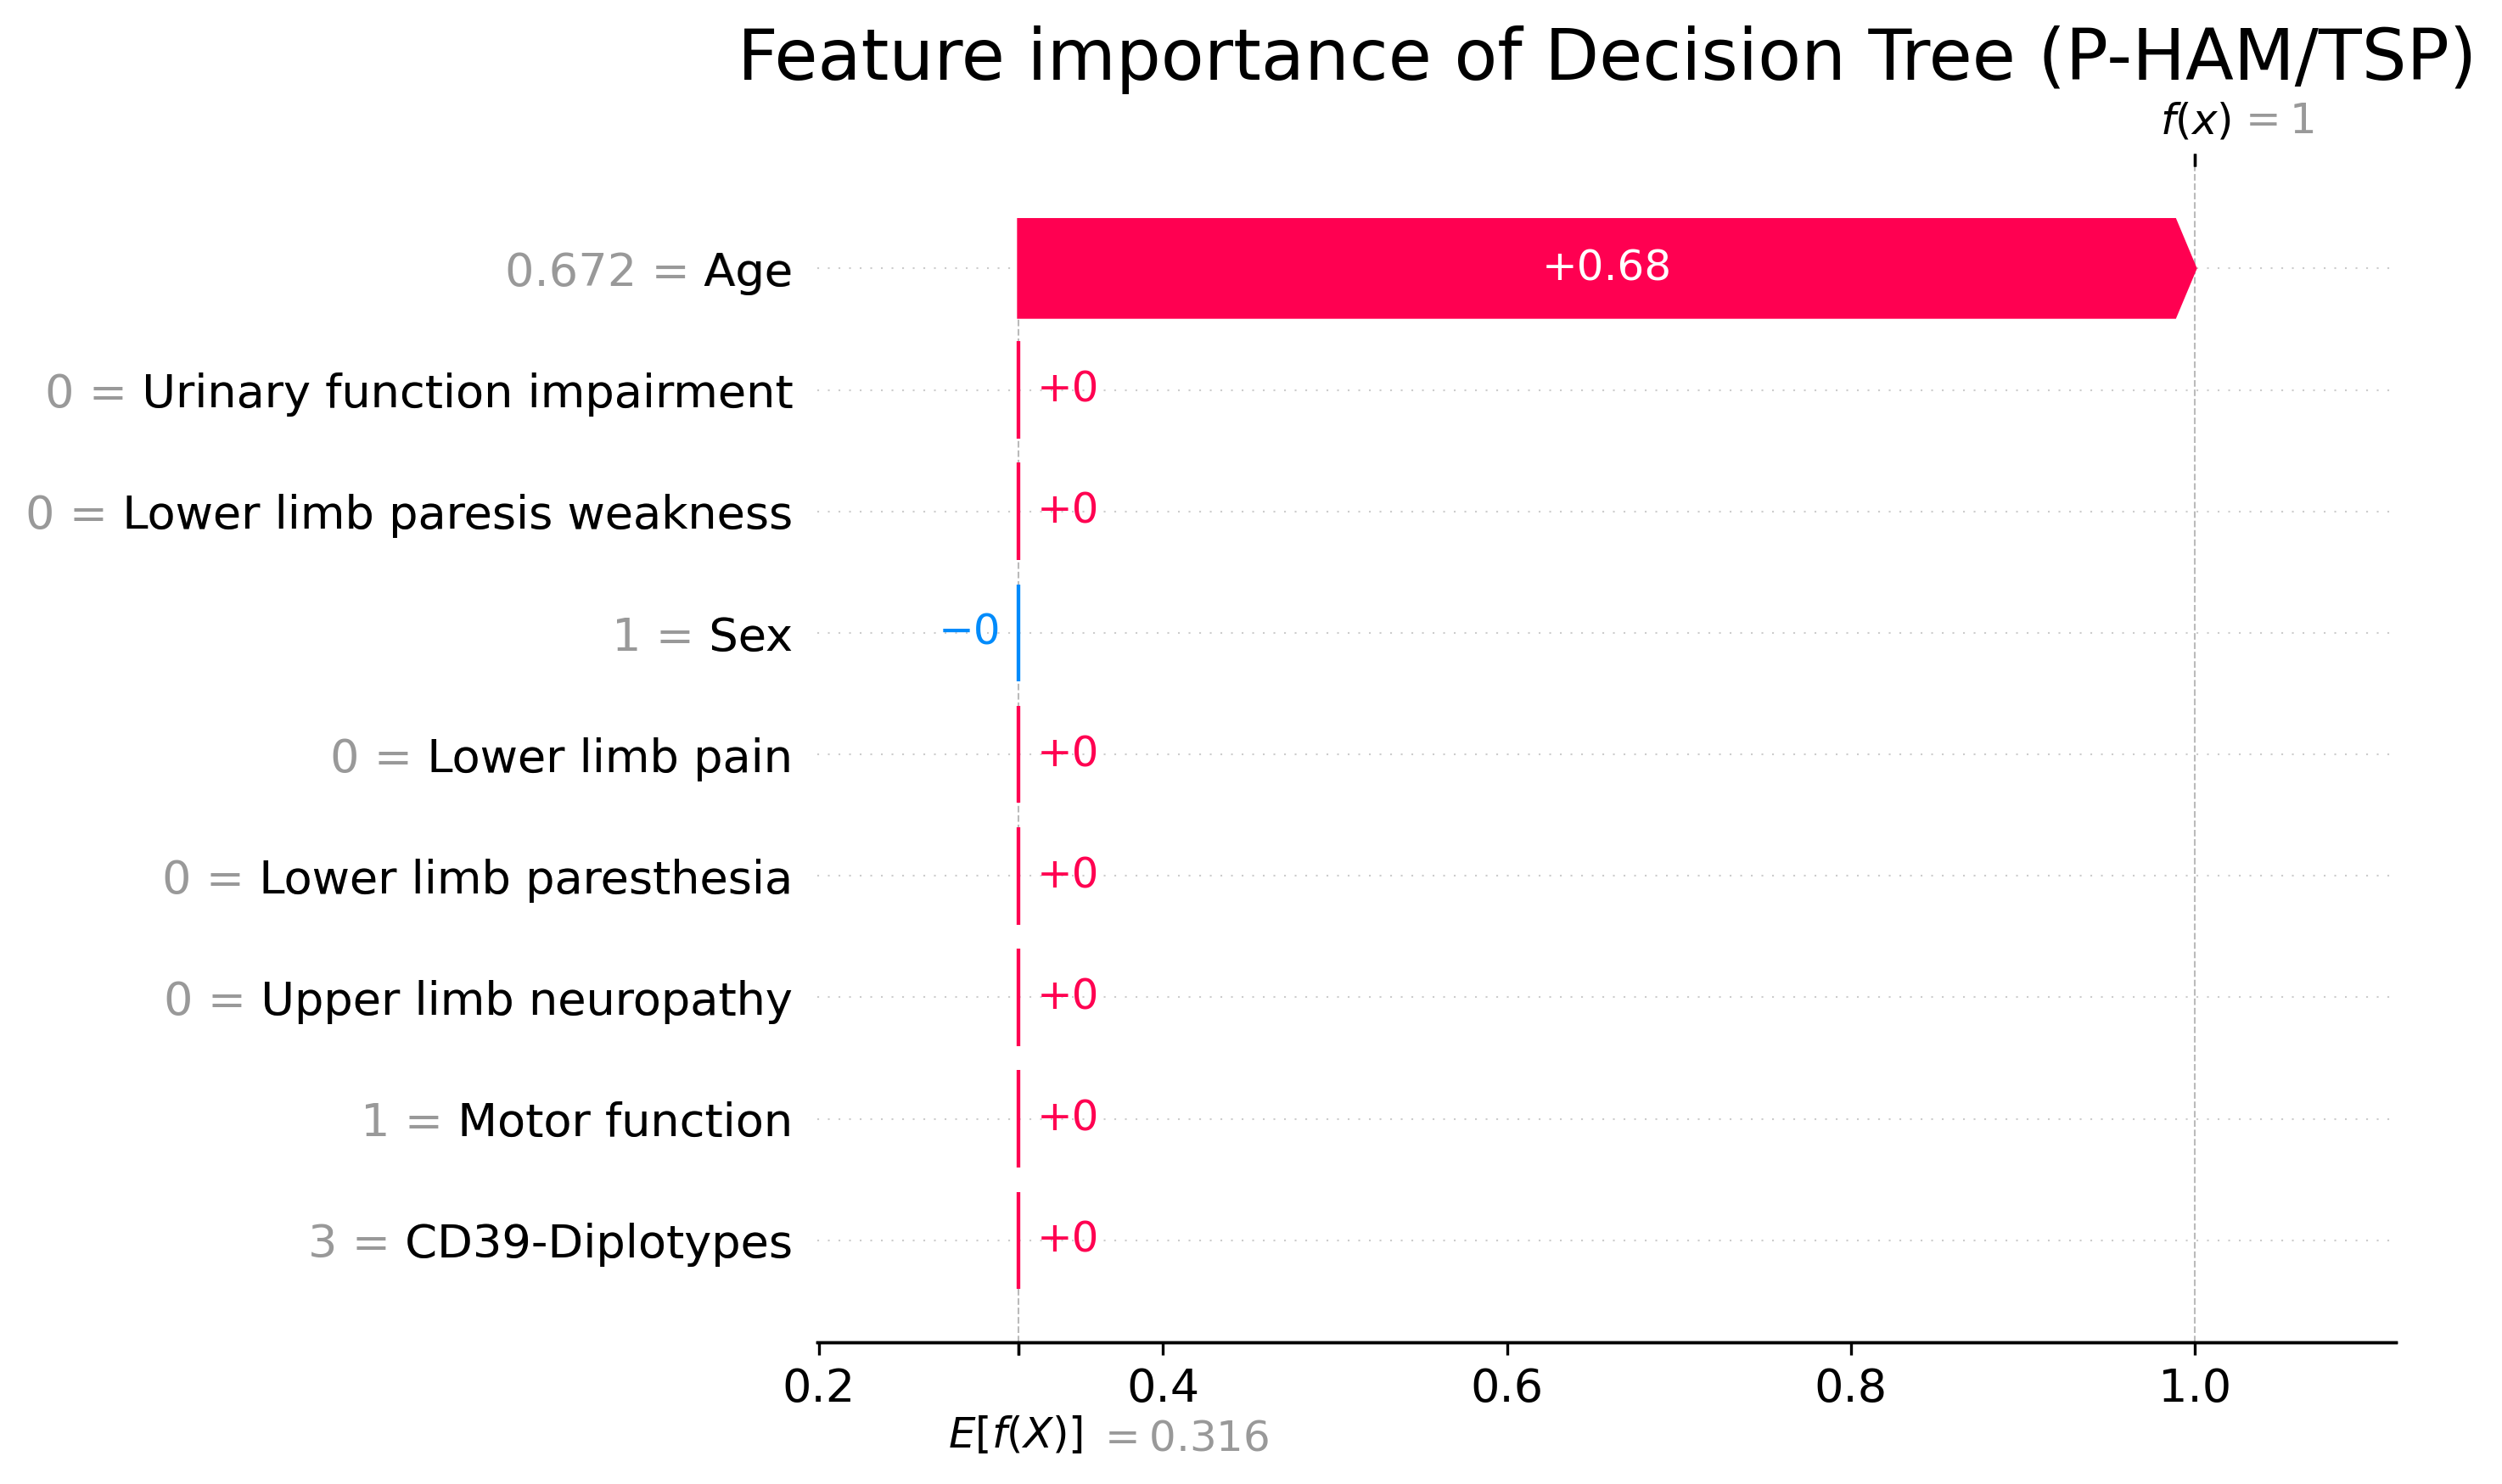

Importância das Características do modelo Gradient Boosting


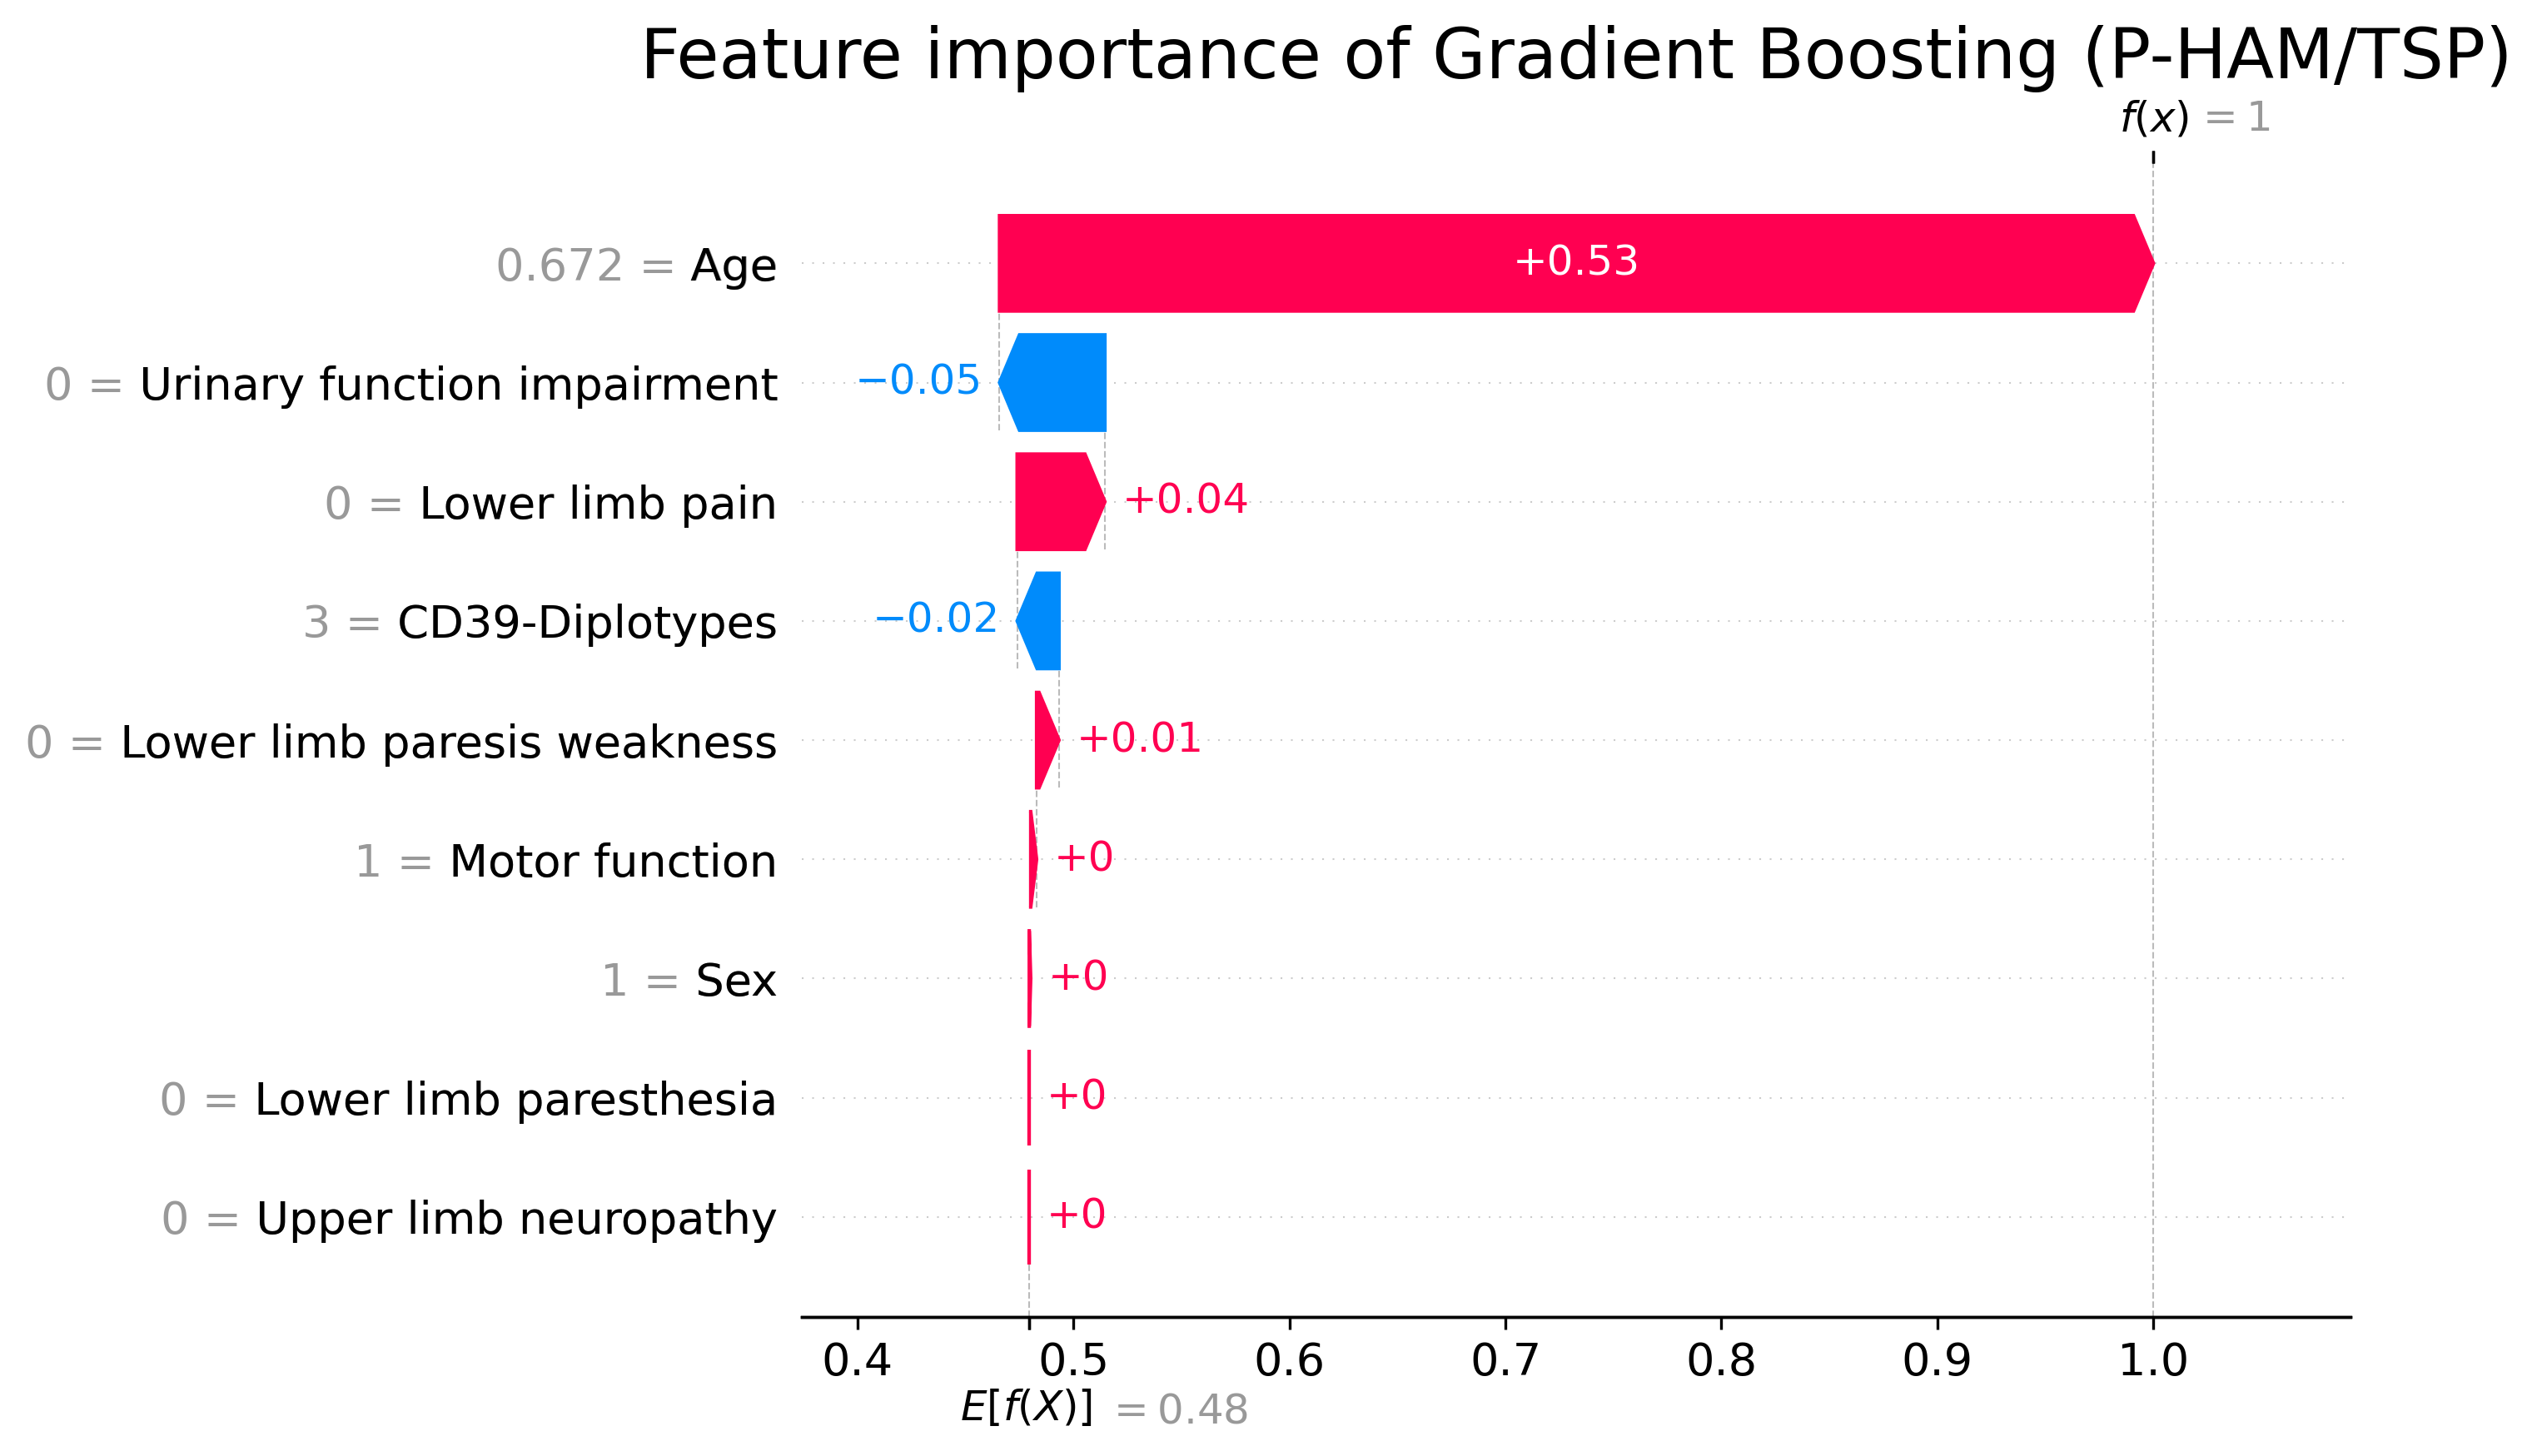

Importância das Características do modelo Logistic Regression


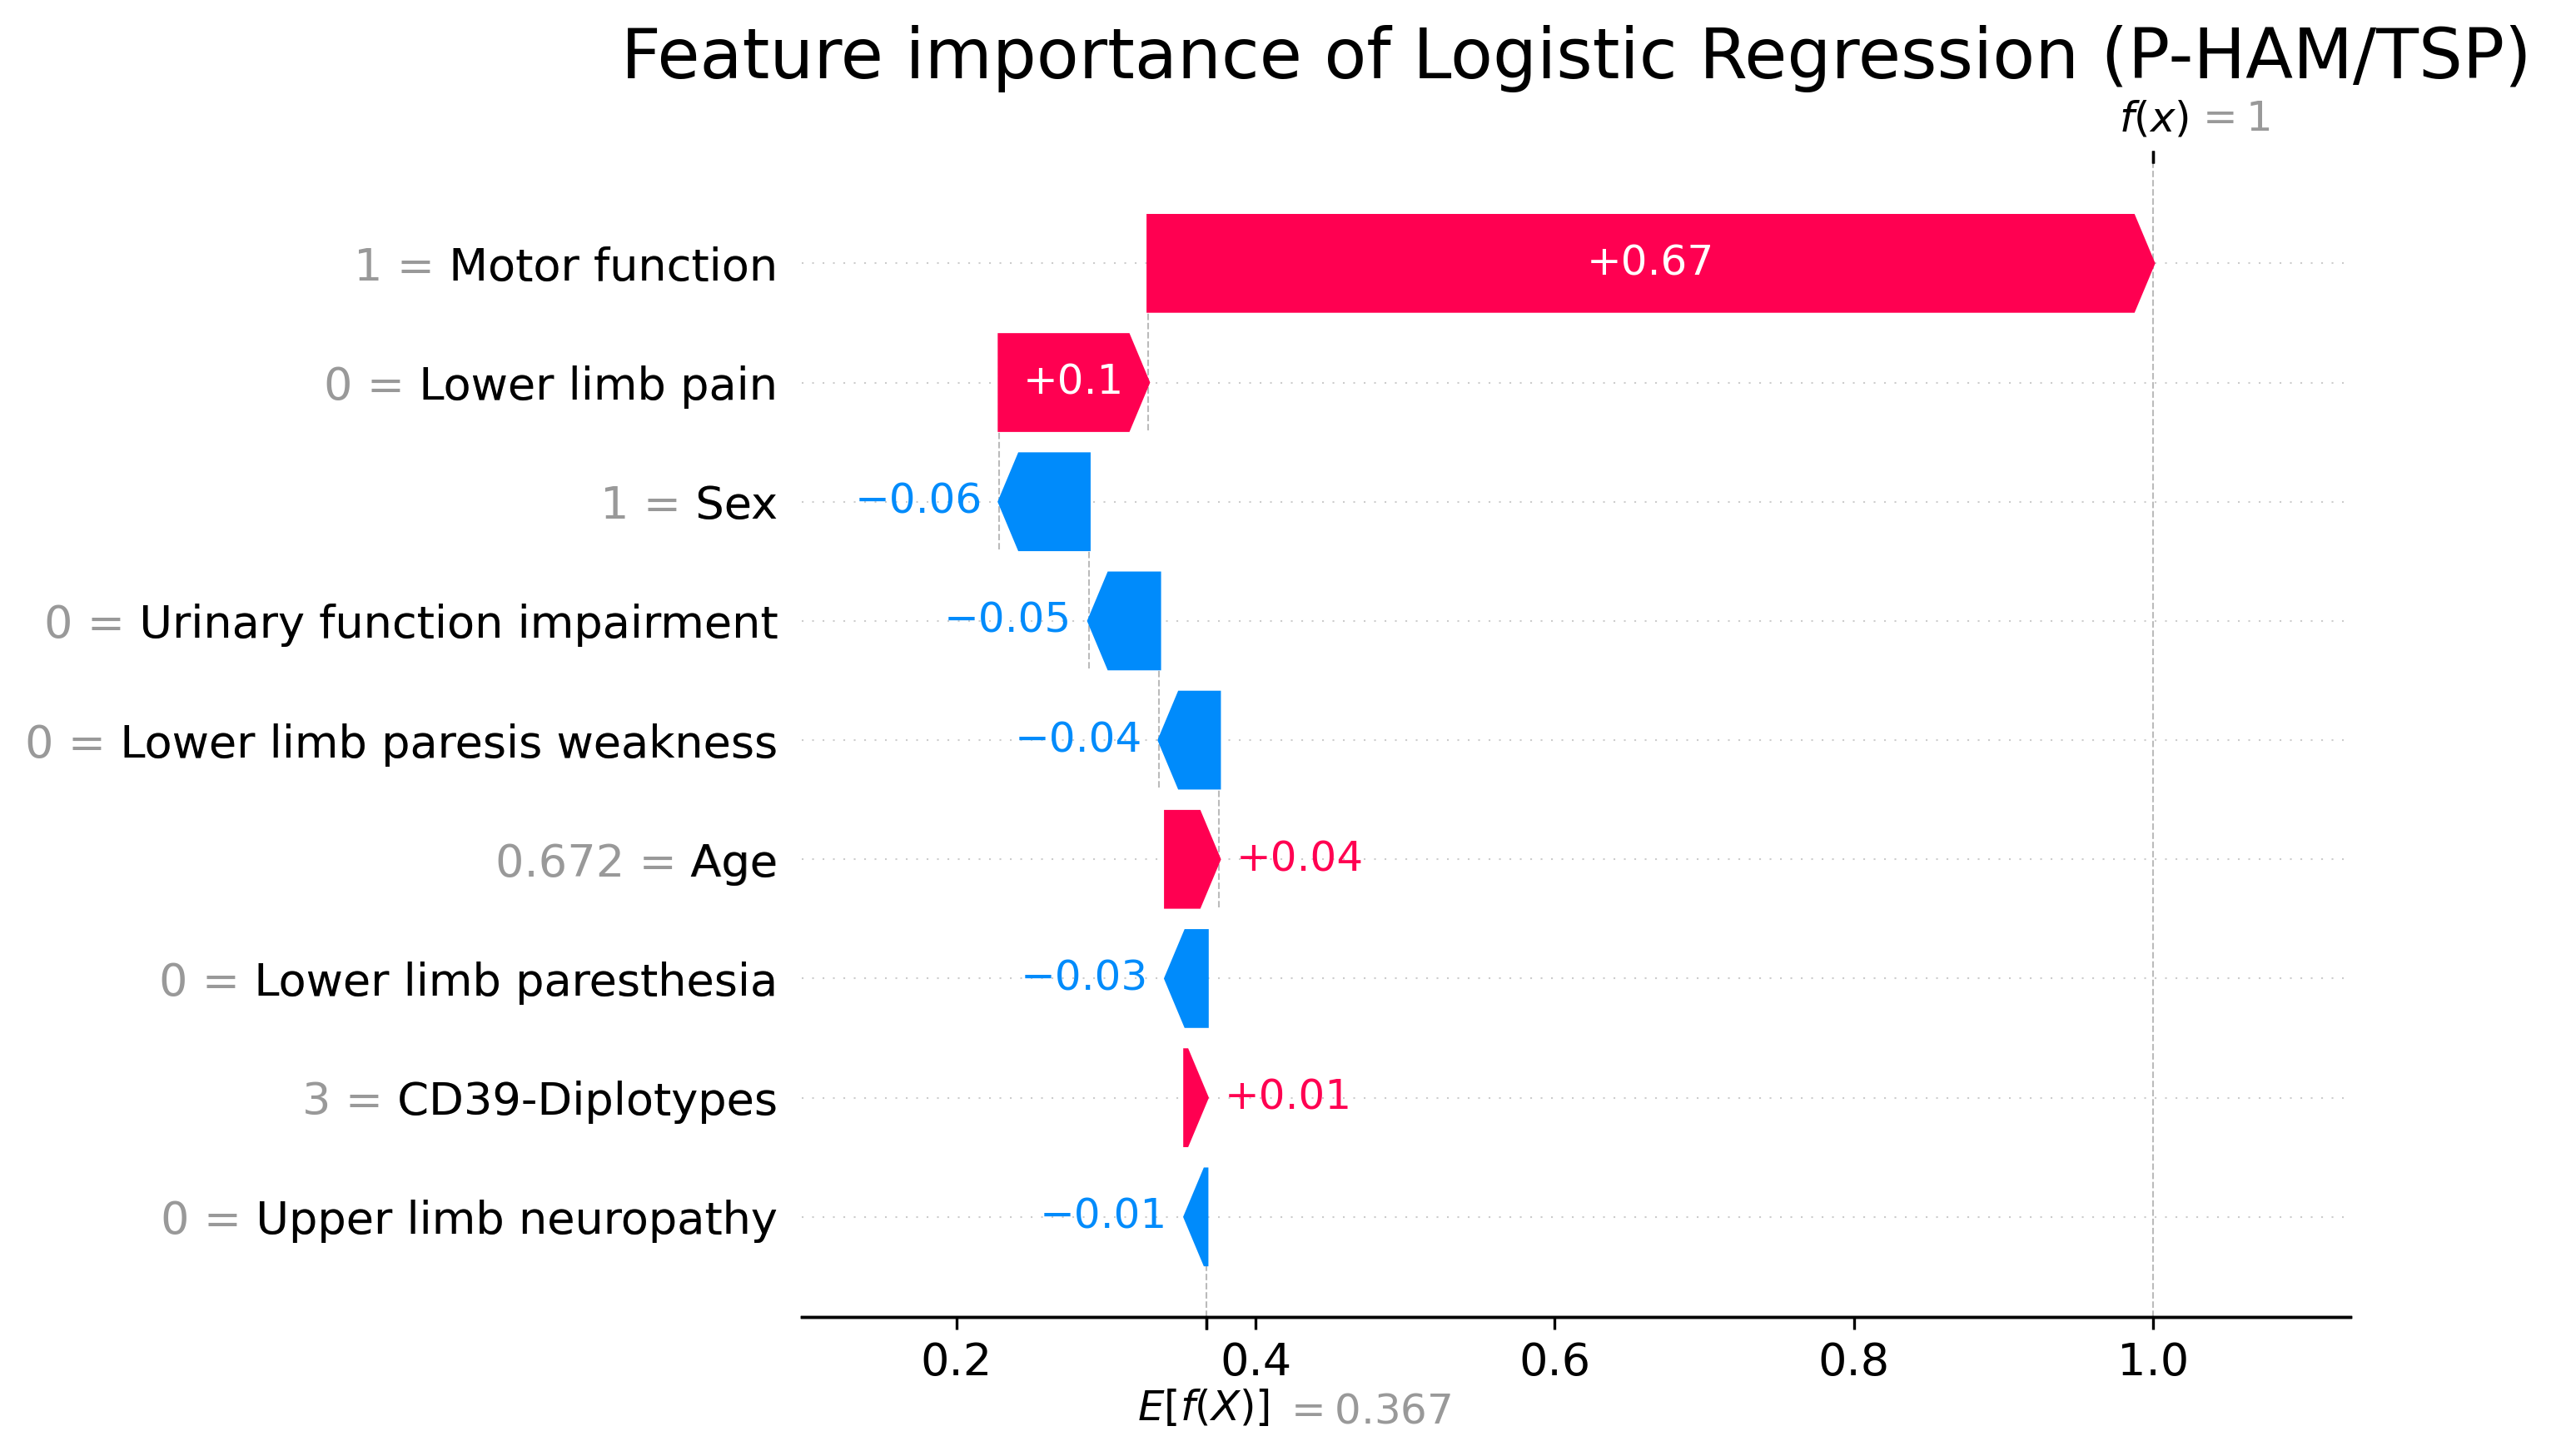

Importância das Características do modelo Multi-layer Perceptron


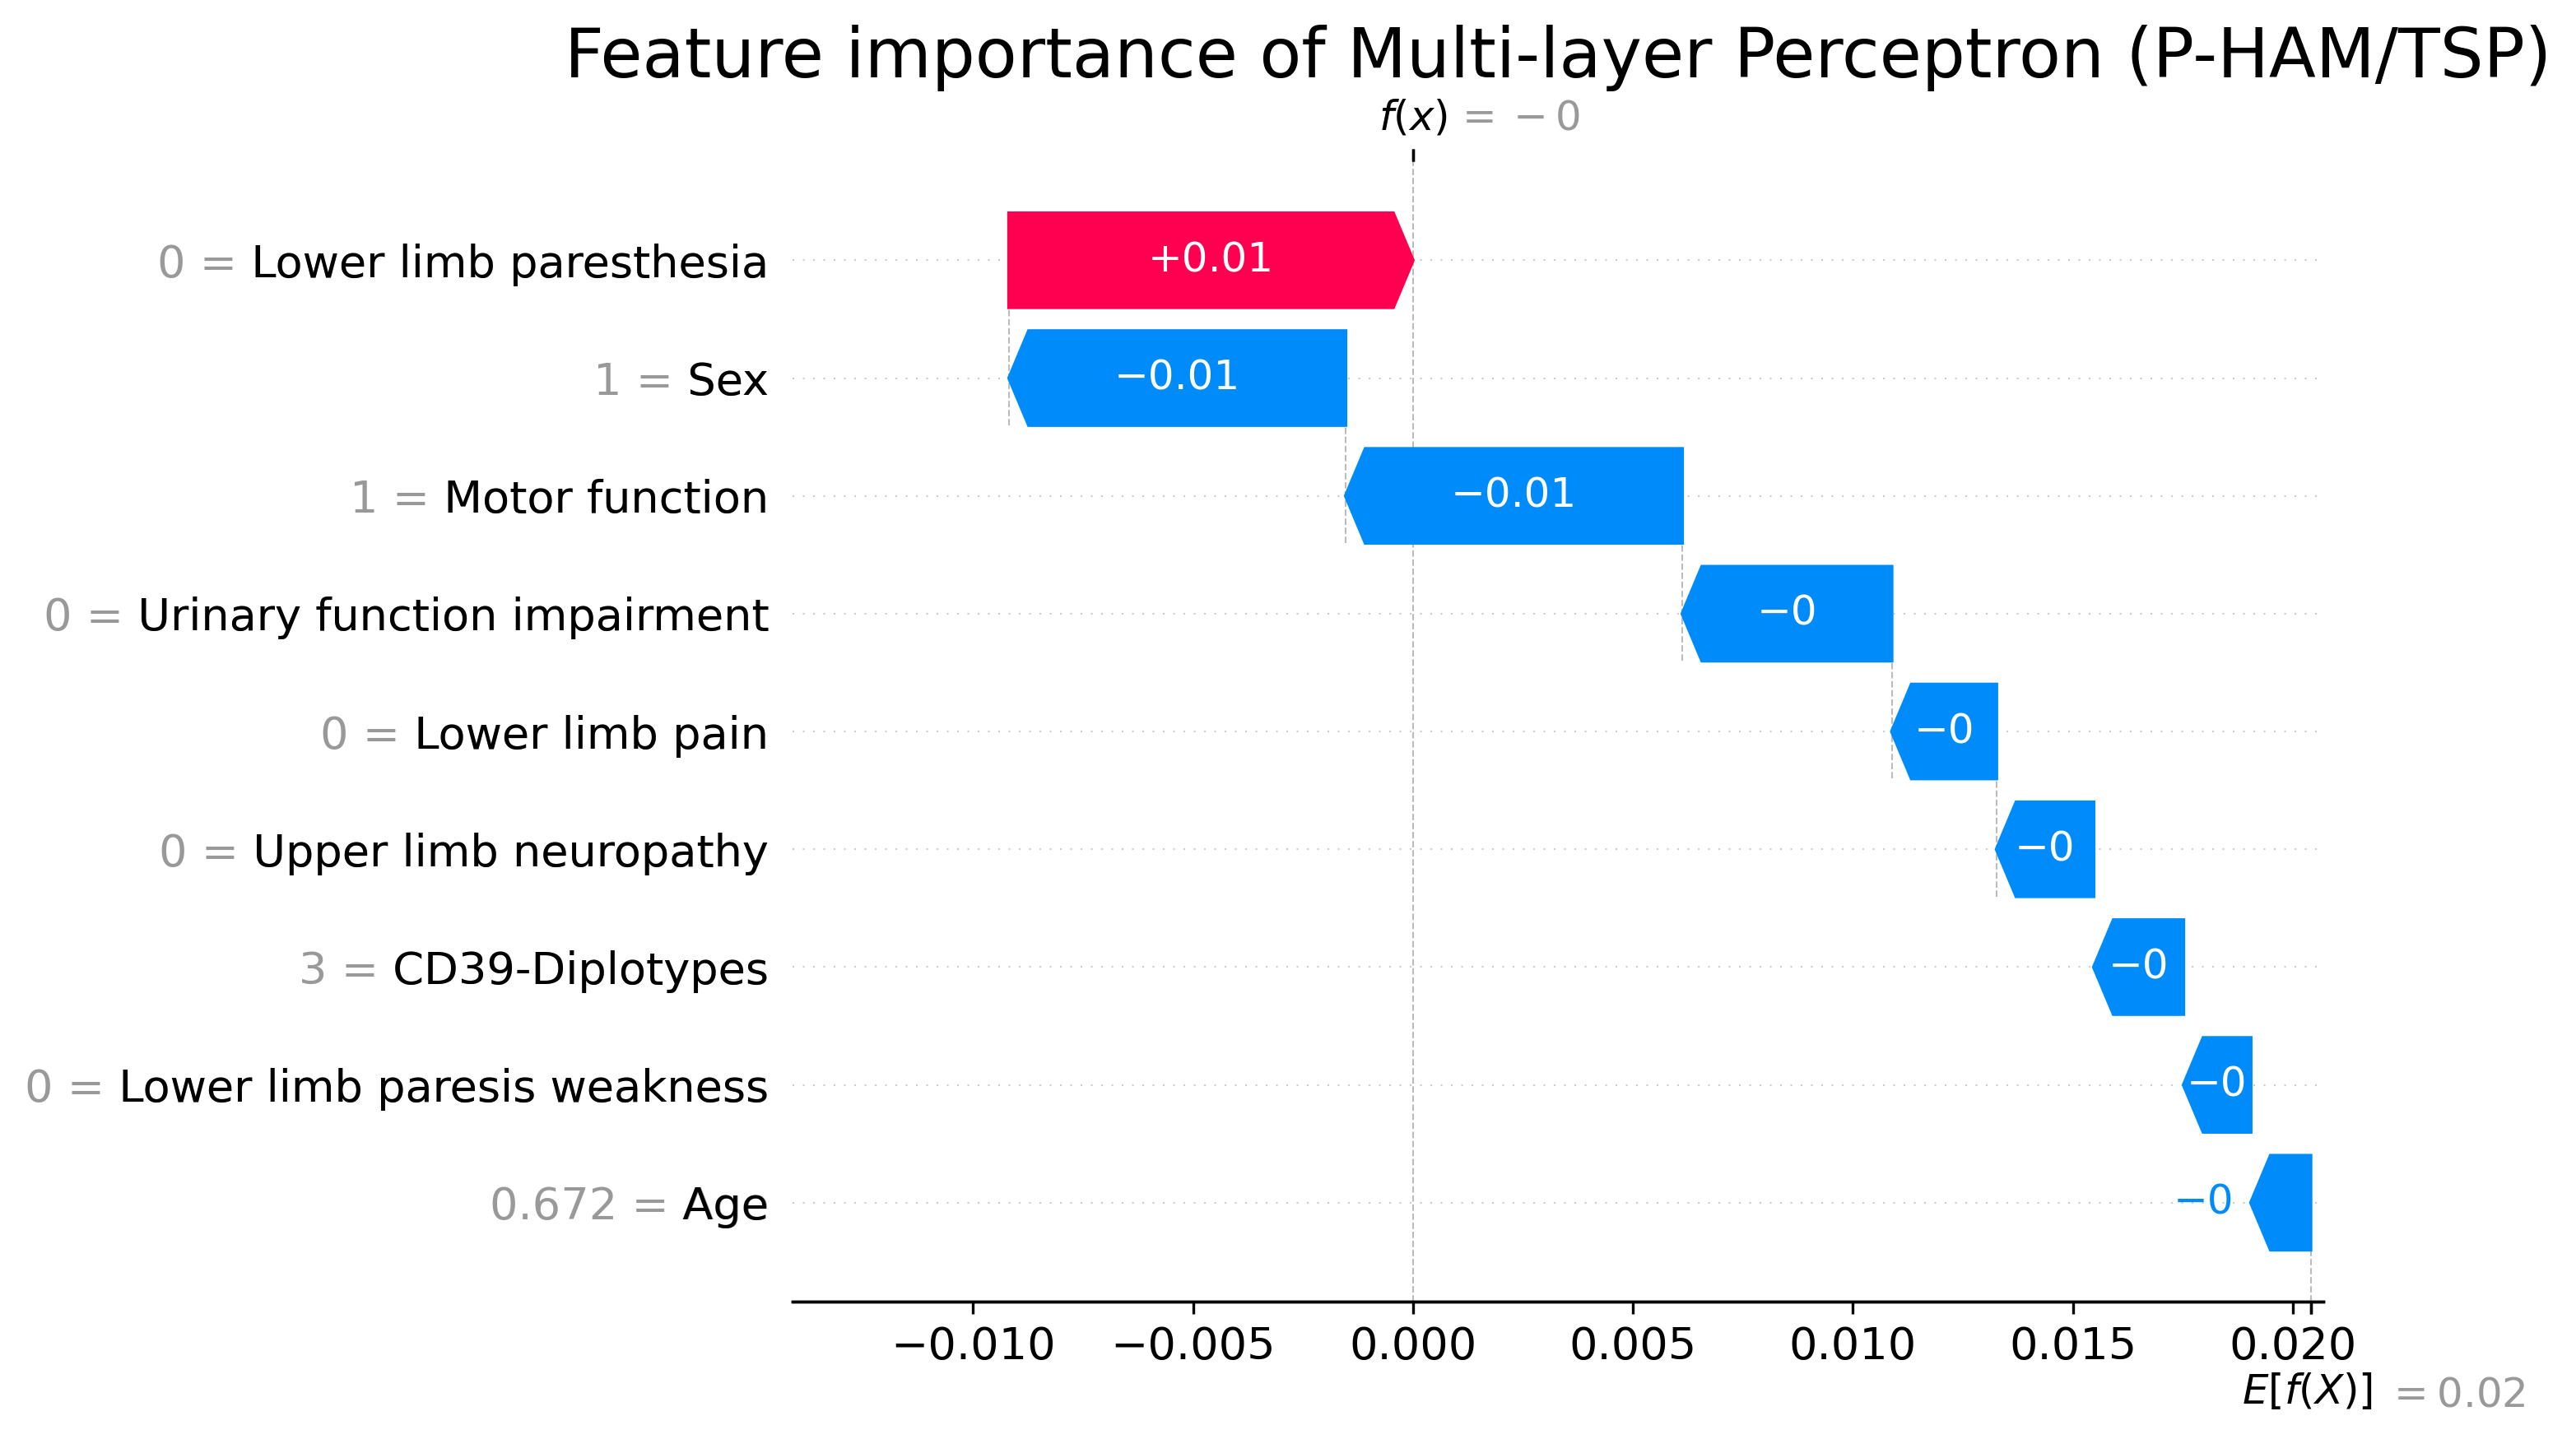

Importância das Características do modelo Naive Bayes


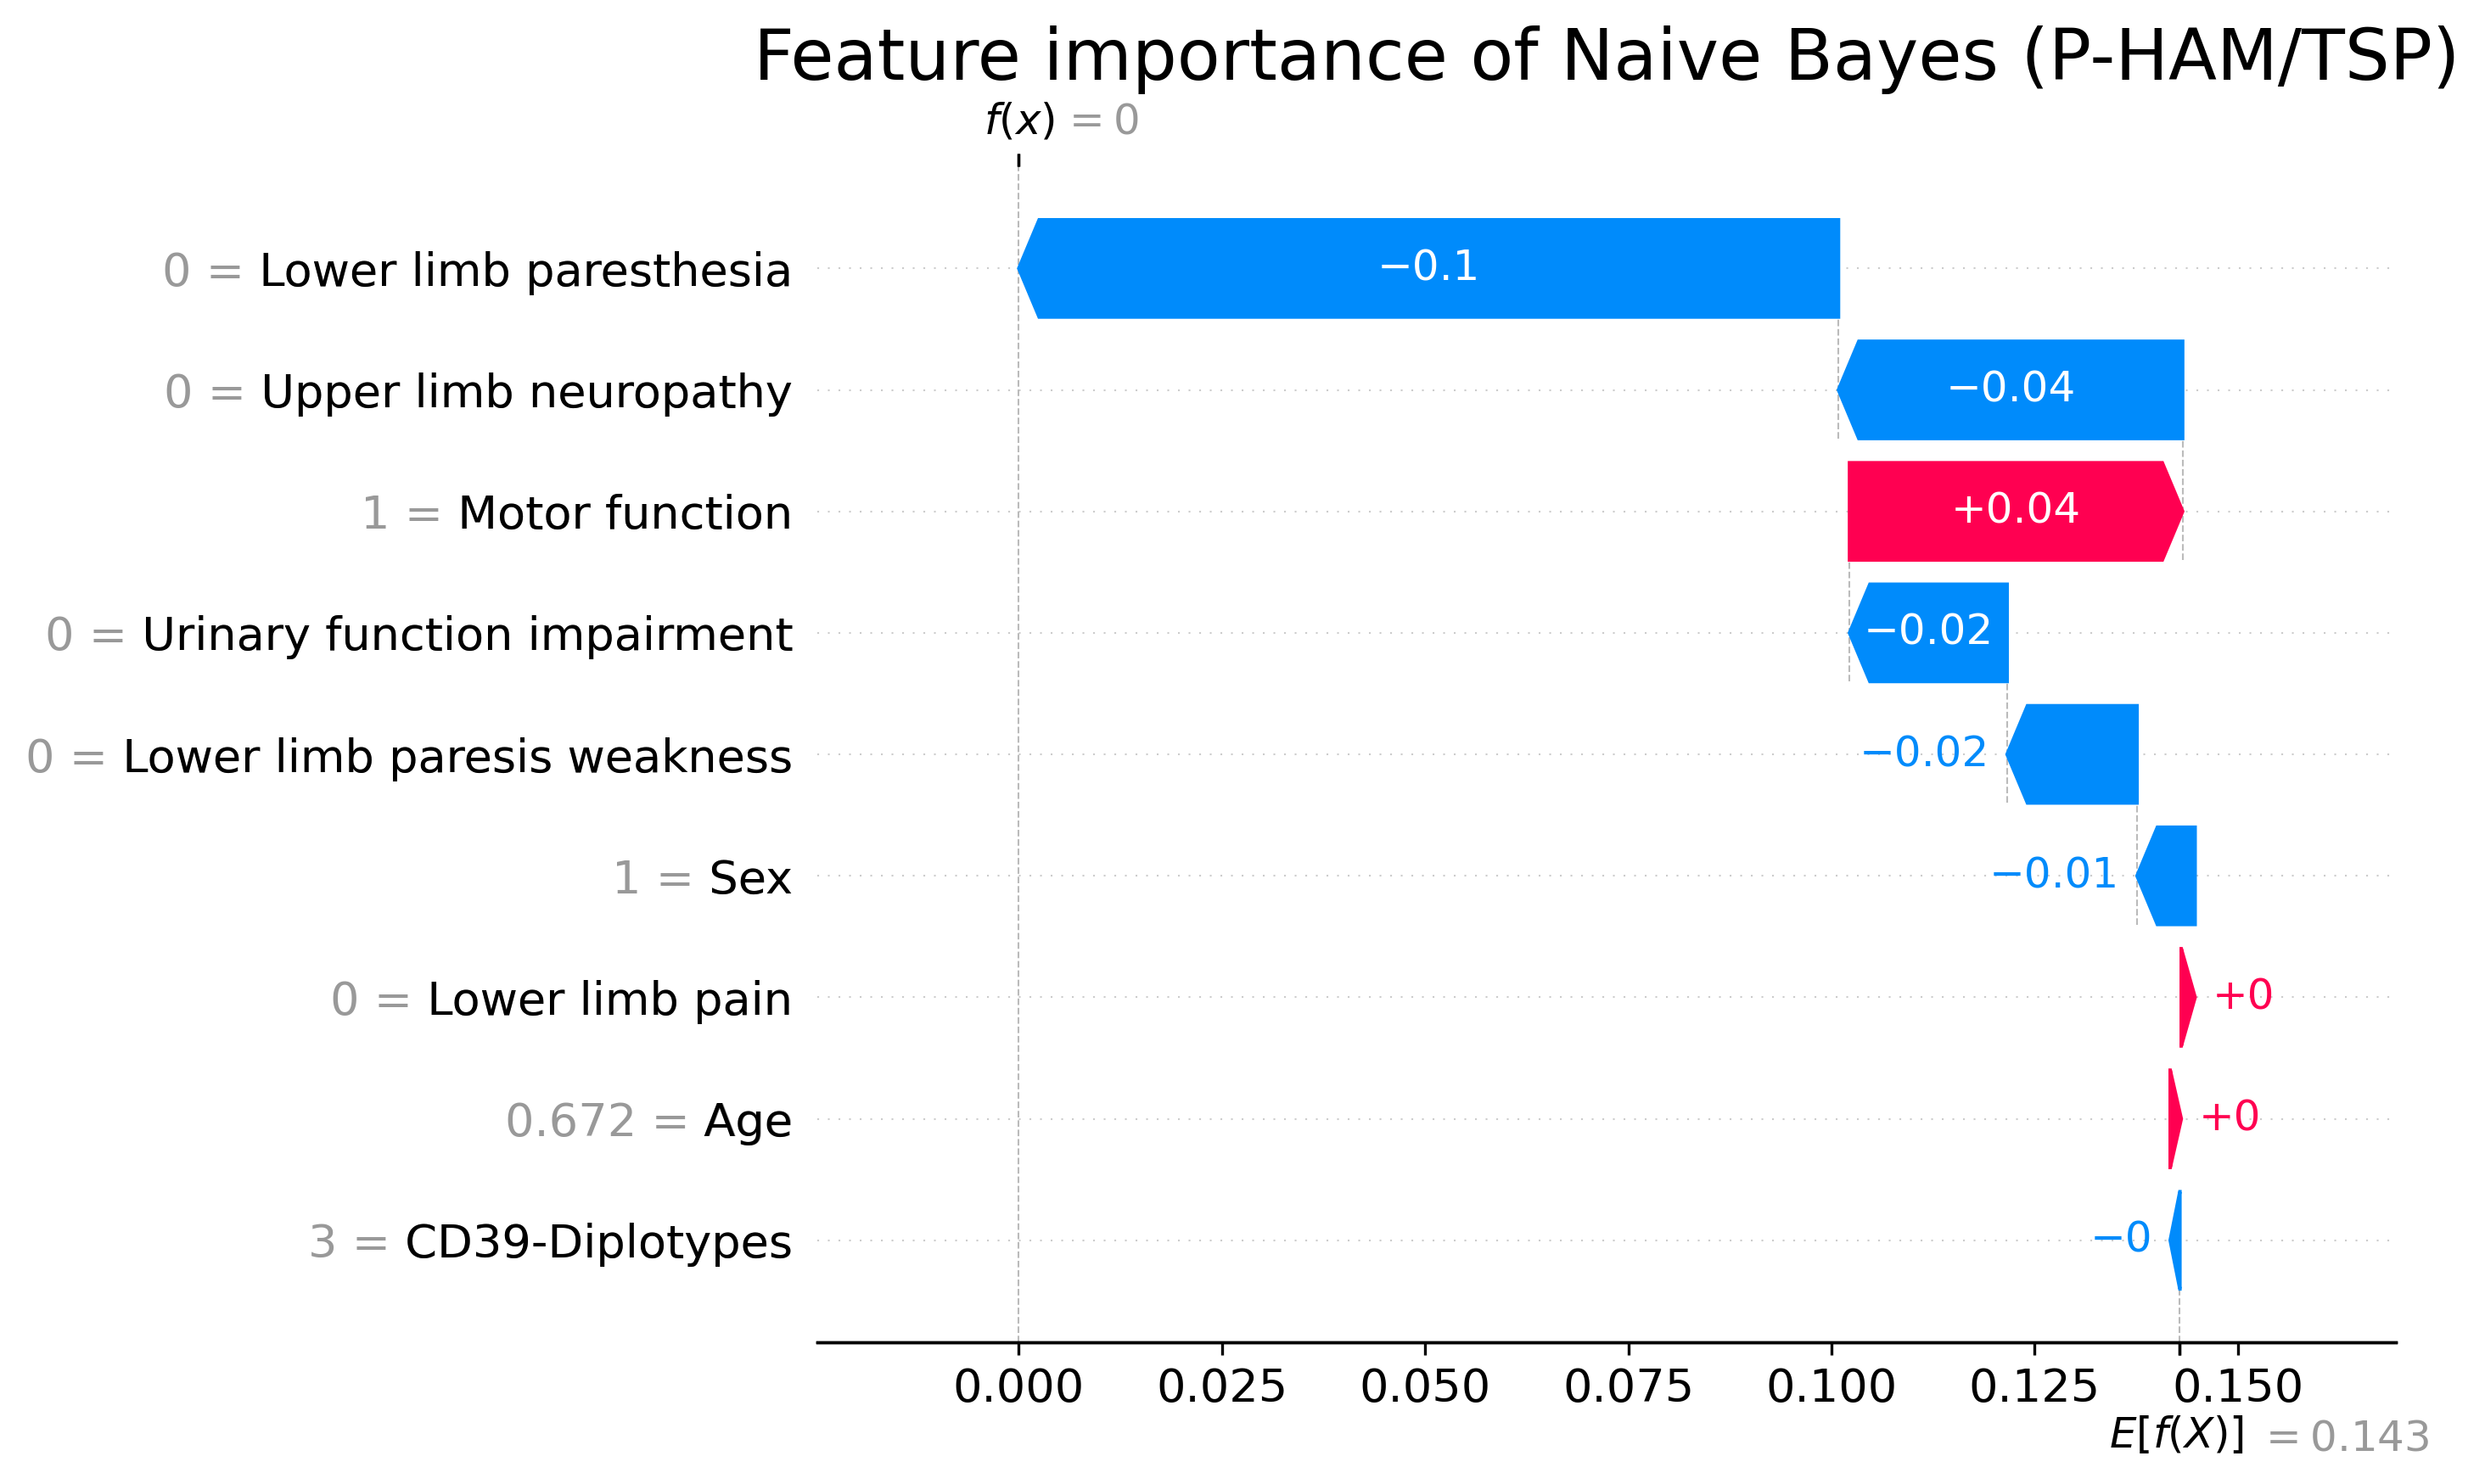

Importância das Características do modelo Random Forest


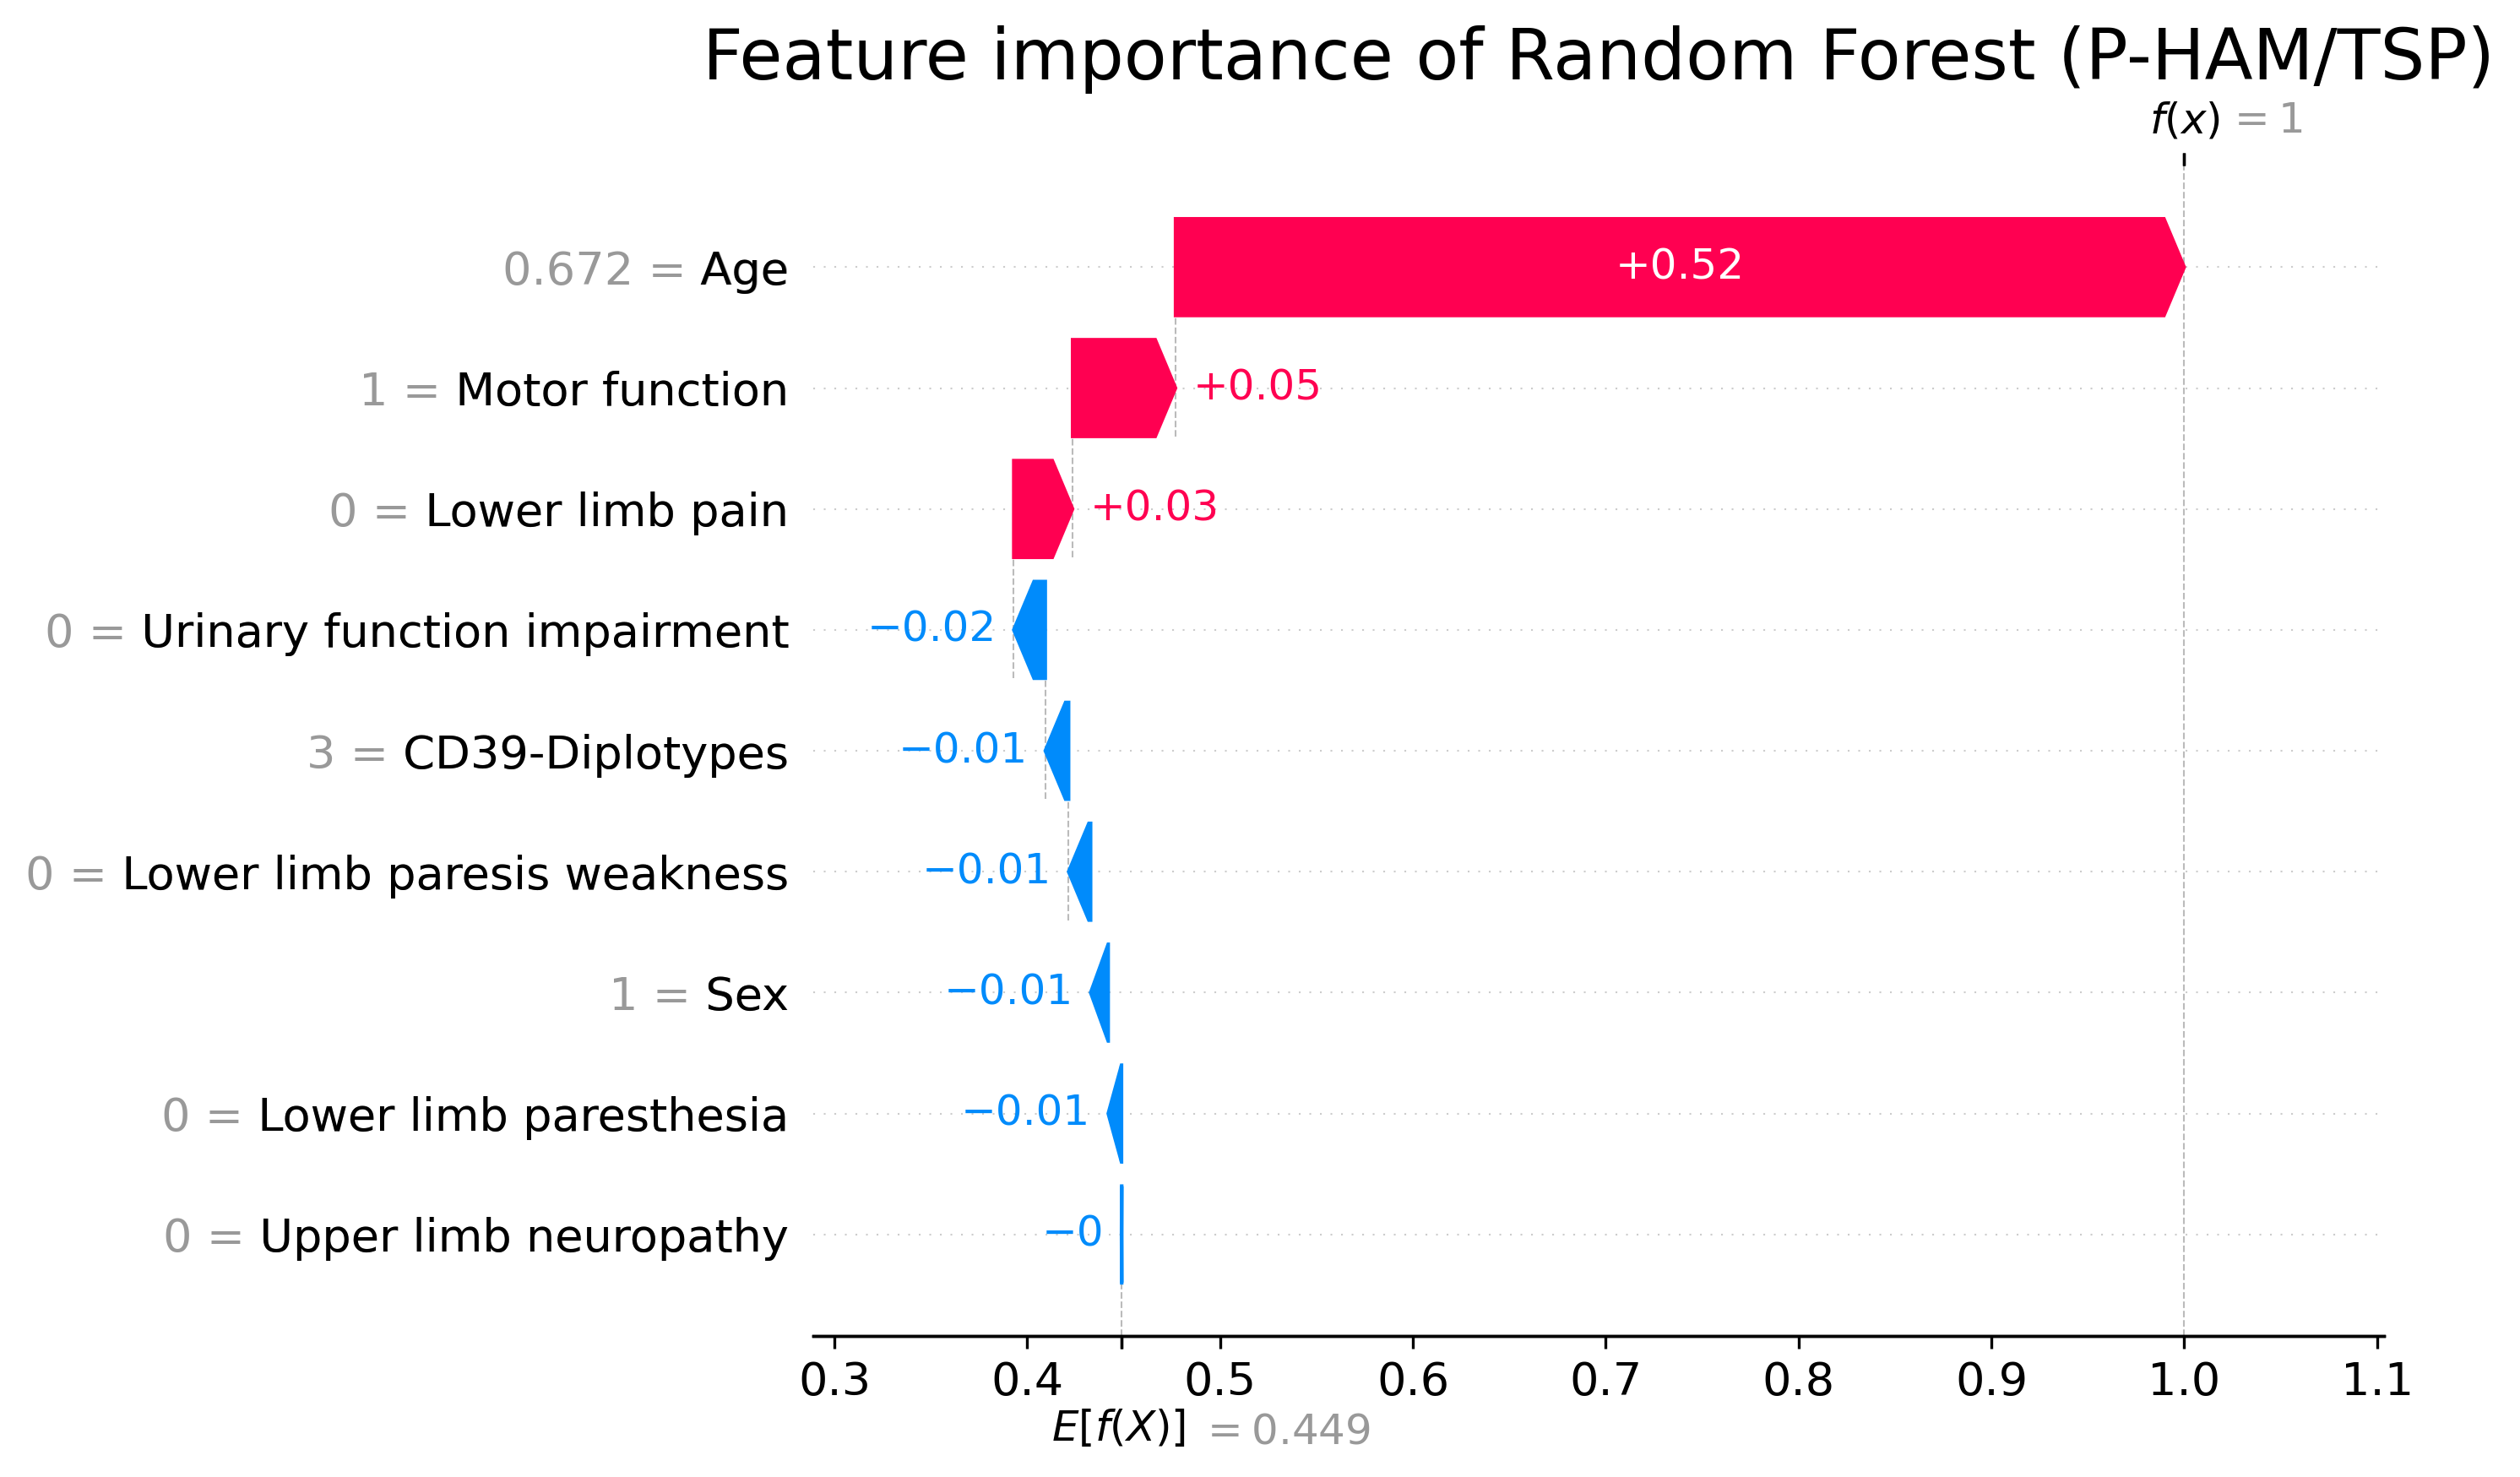

ExactExplainer explainer: 99it [00:14,  2.36it/s]                        


Importância das Características do modelo Support Vector Machine


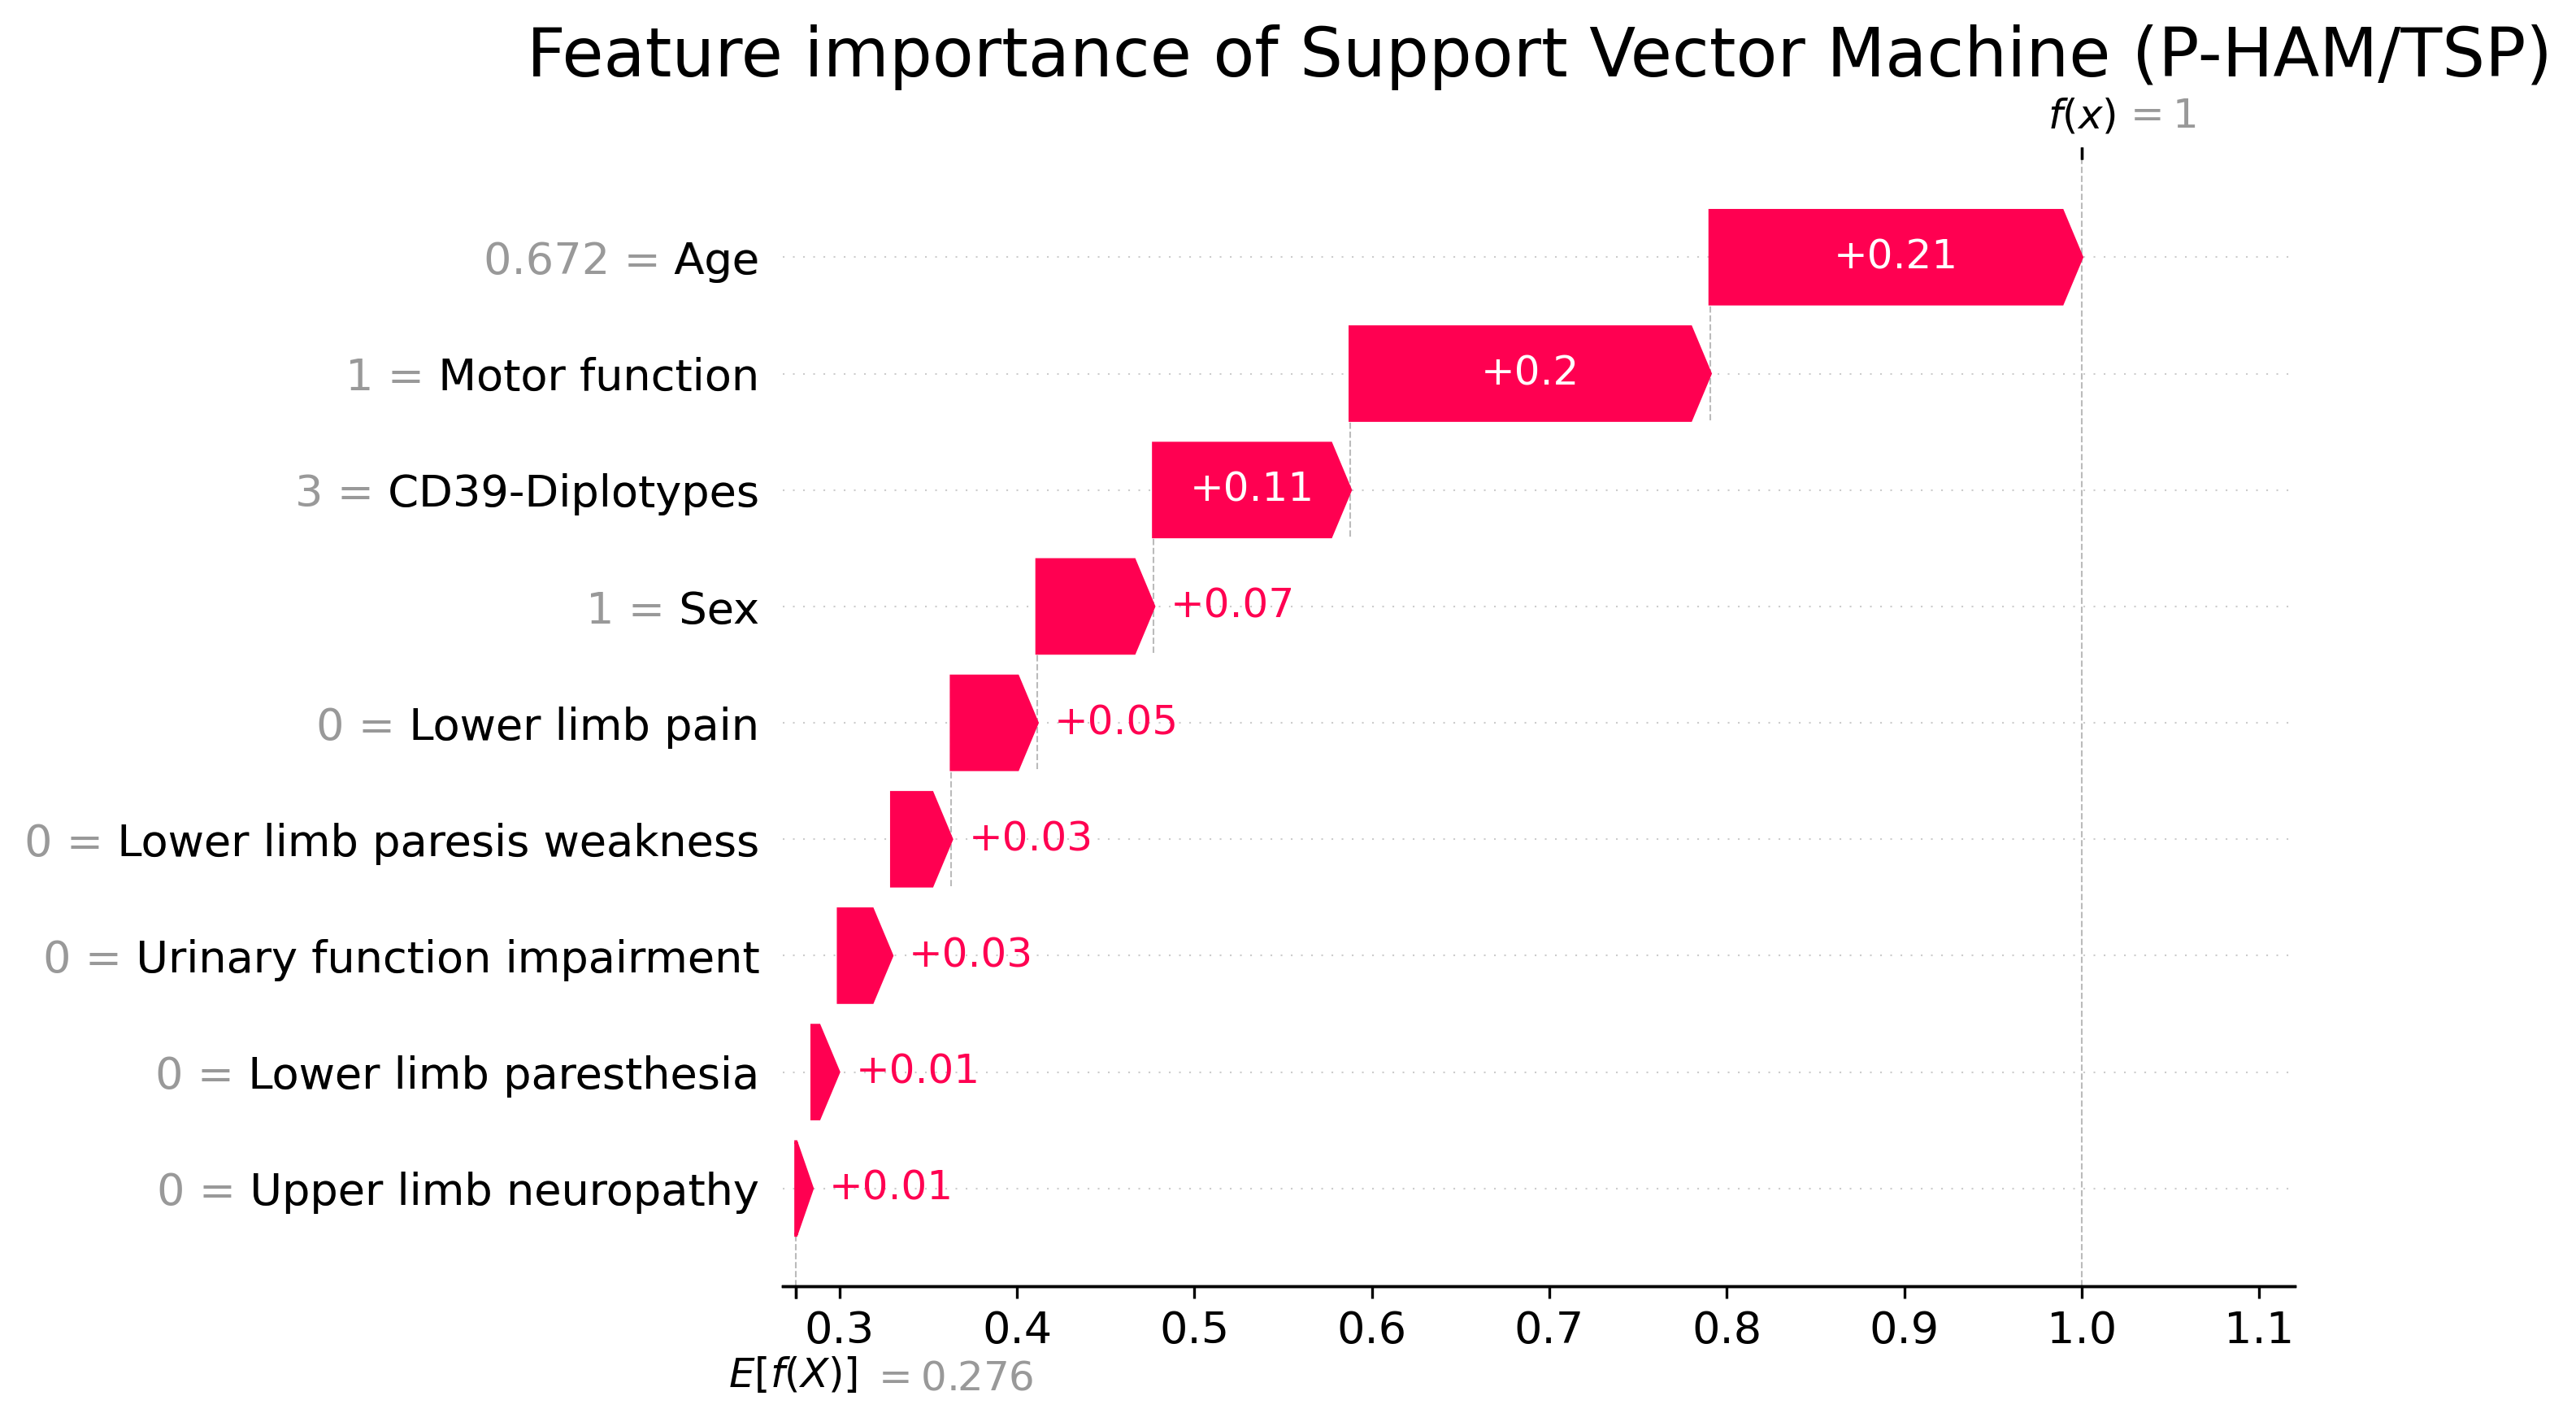

ExactExplainer explainer: 99it [01:09,  1.24it/s]                        


Importância das Características do modelo K-Nearest Neighbors


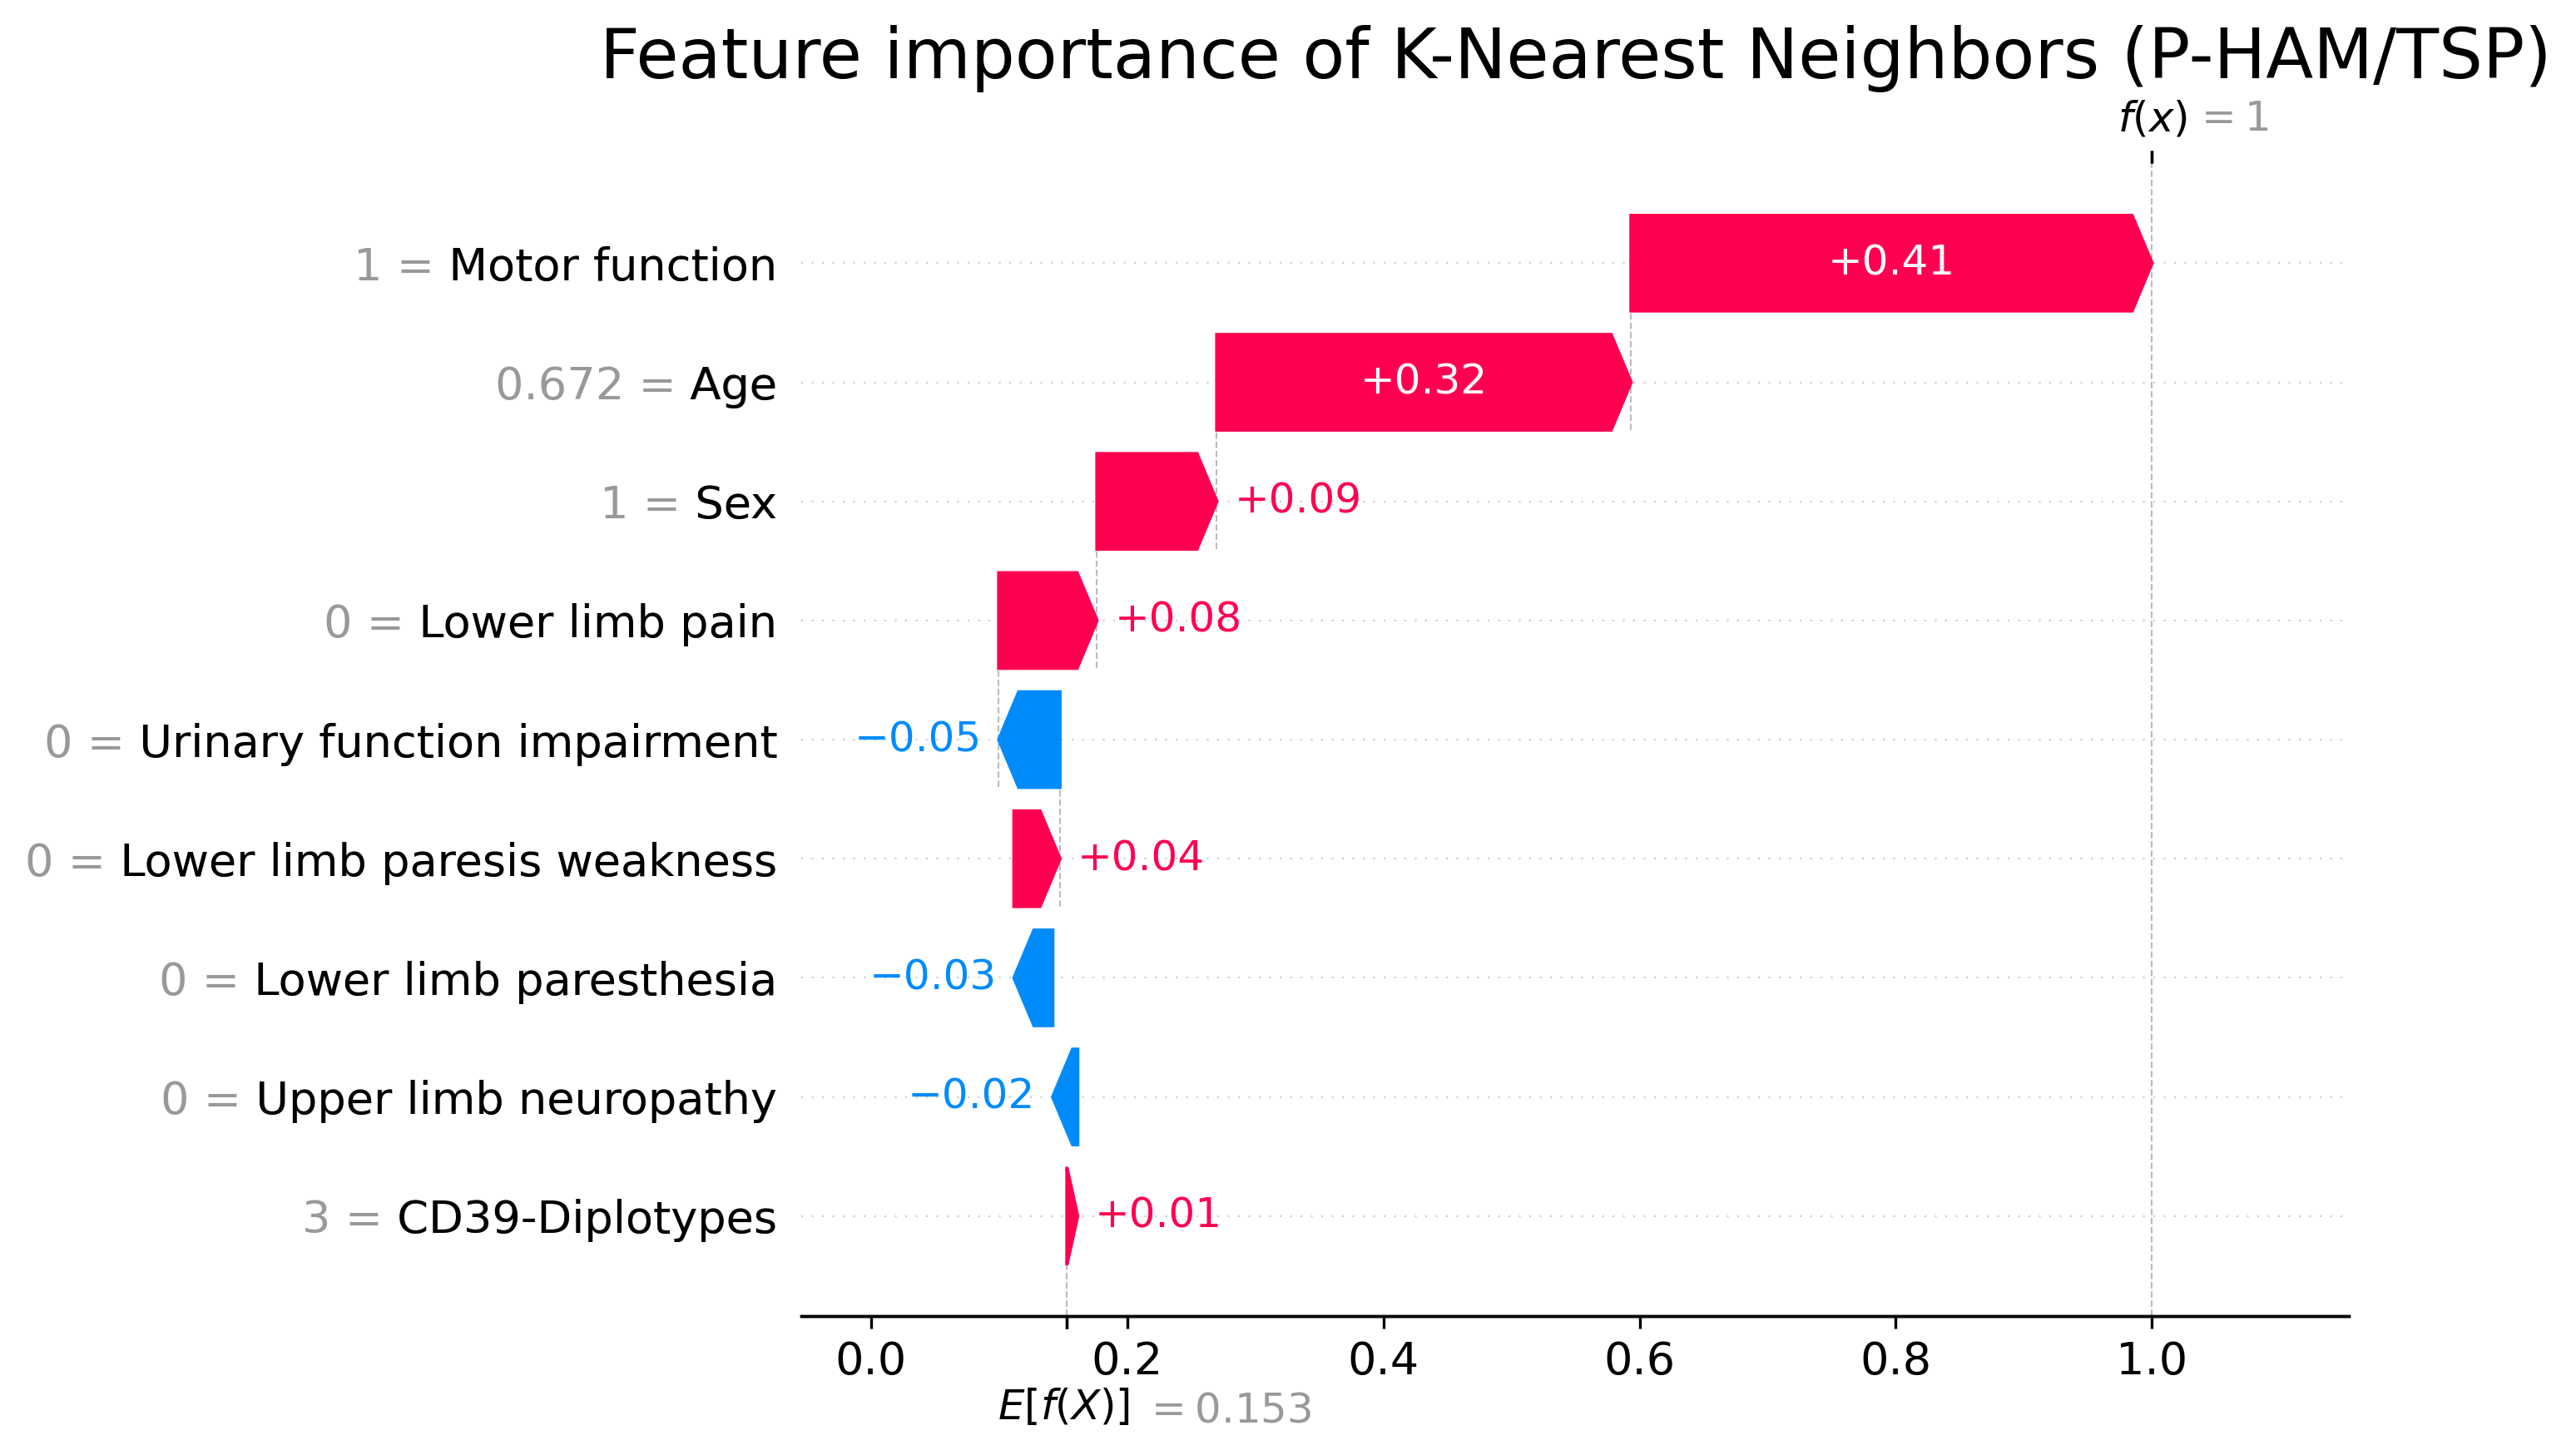

ExactExplainer explainer: 99it [01:12,  1.19it/s]                        


Importância das Características do modelo AdaBoost


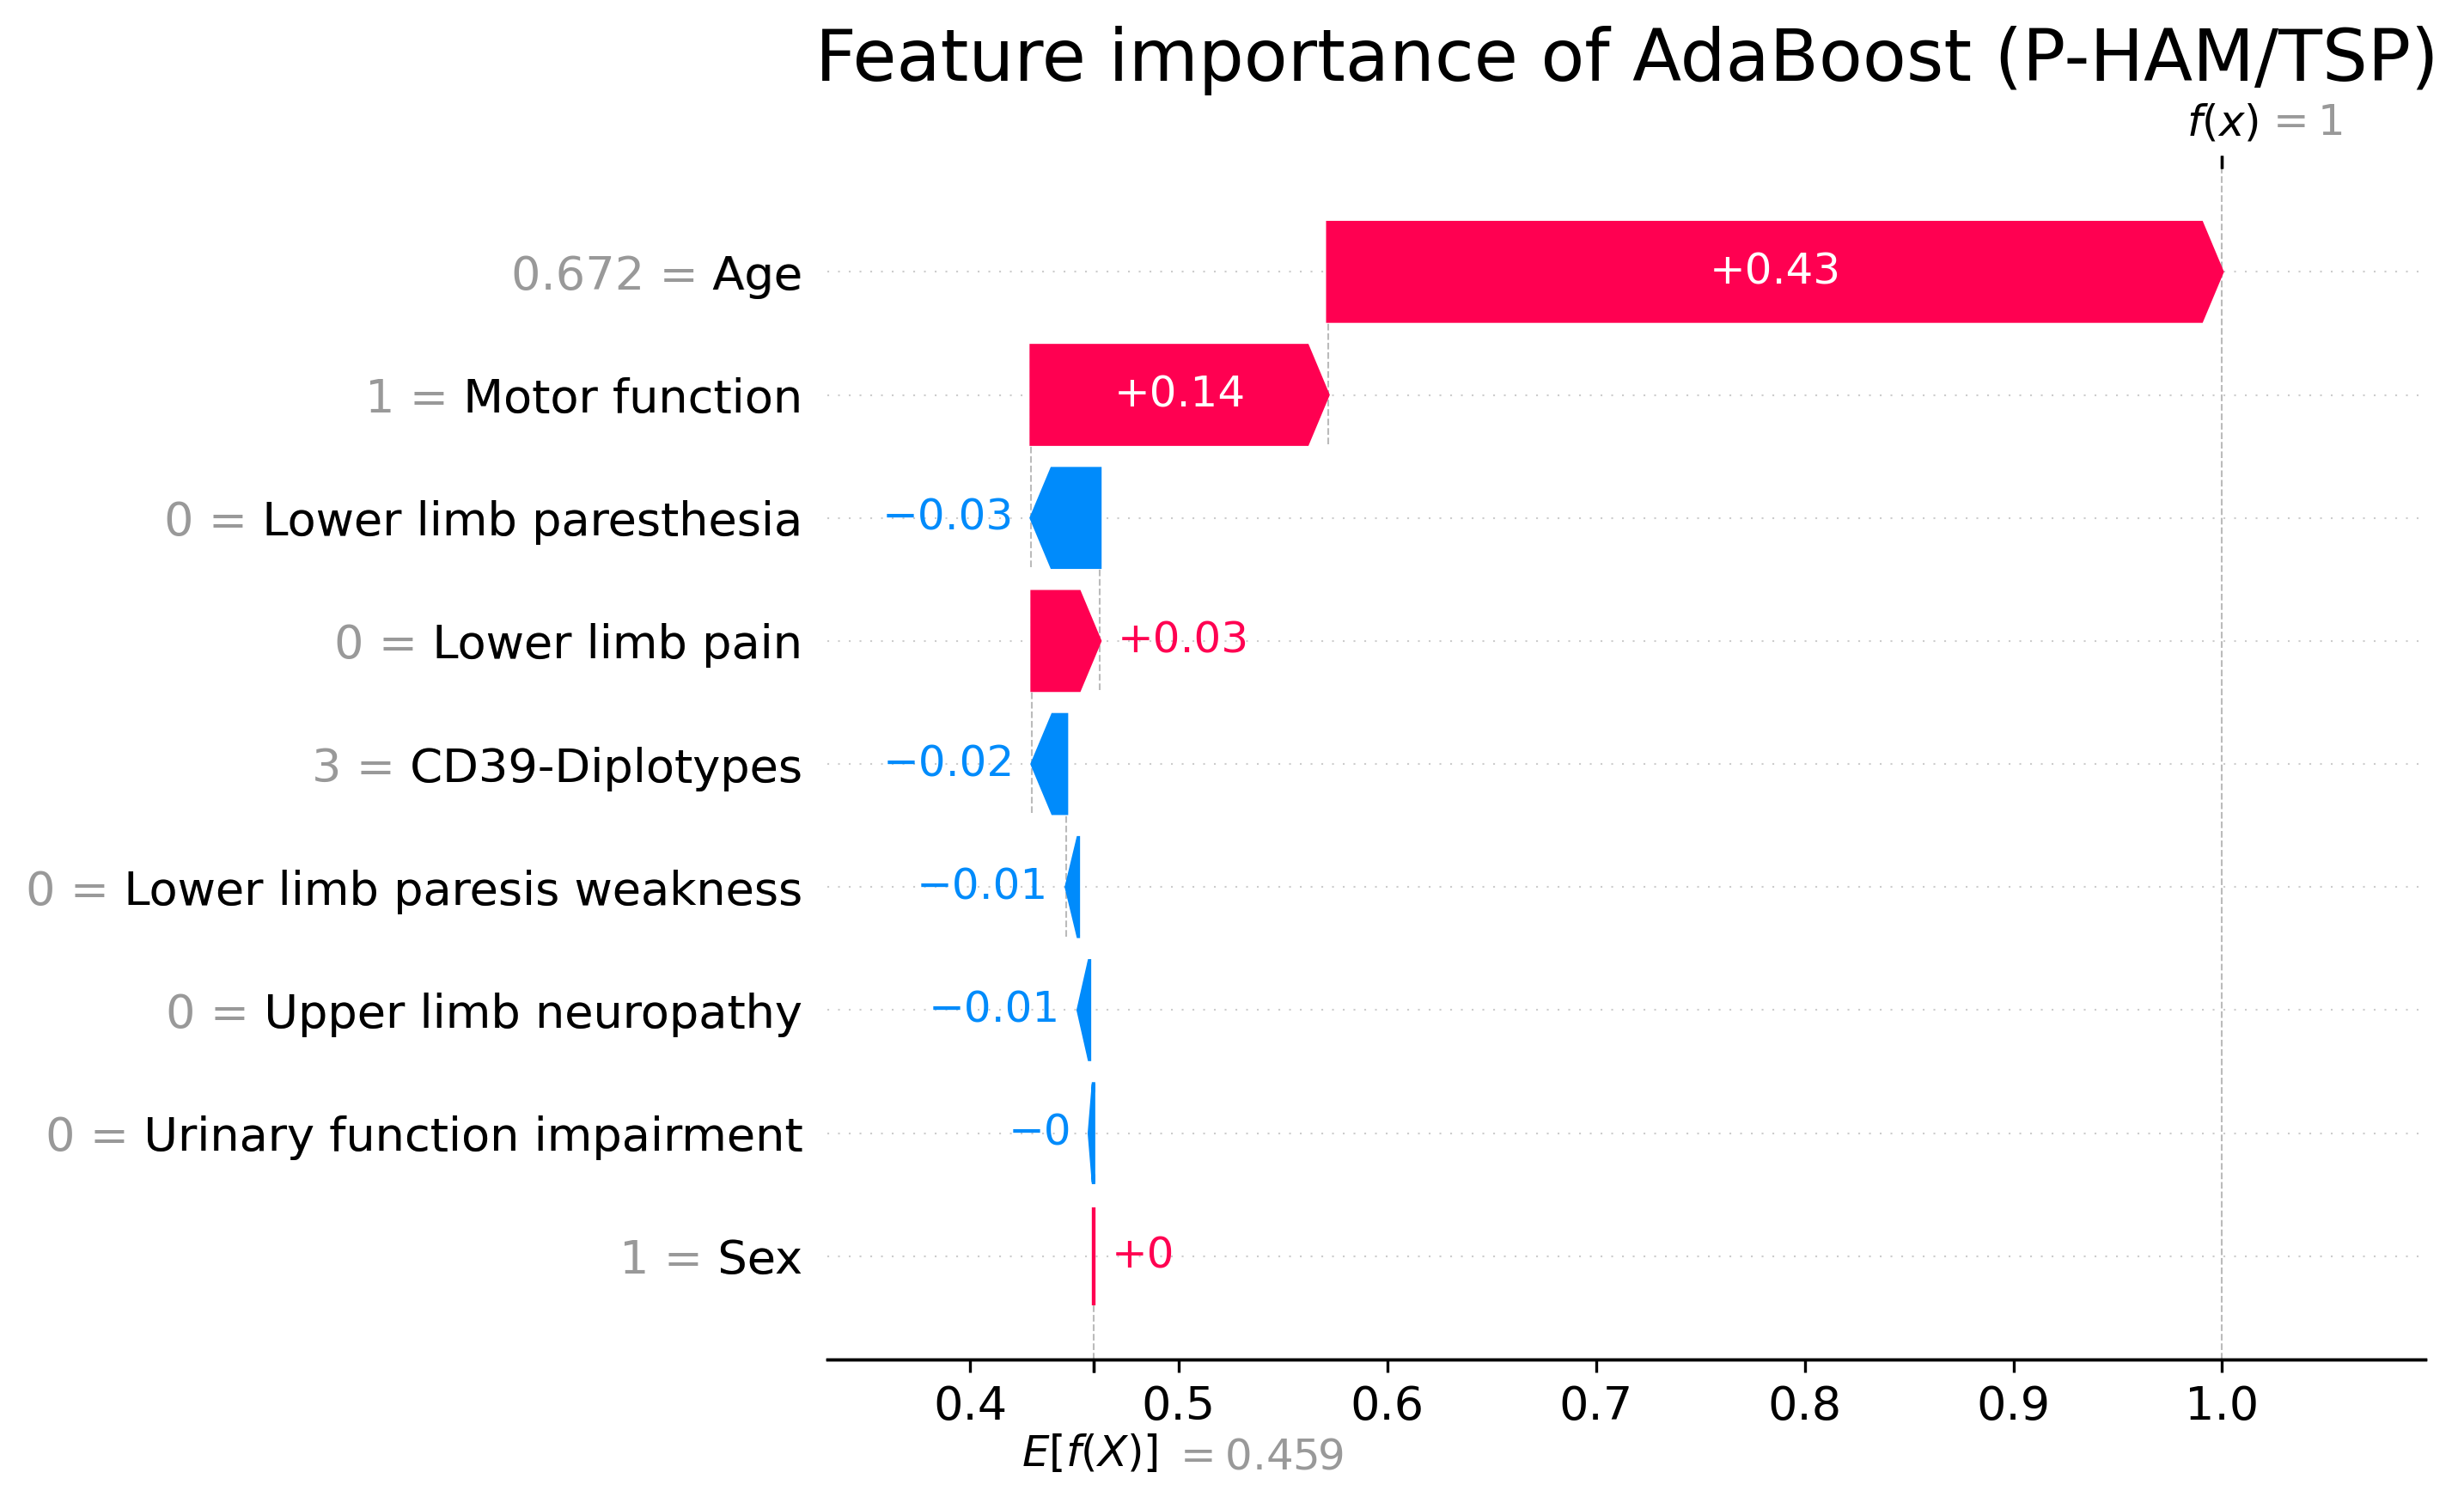

Importância das Características do modelo Linear SVM


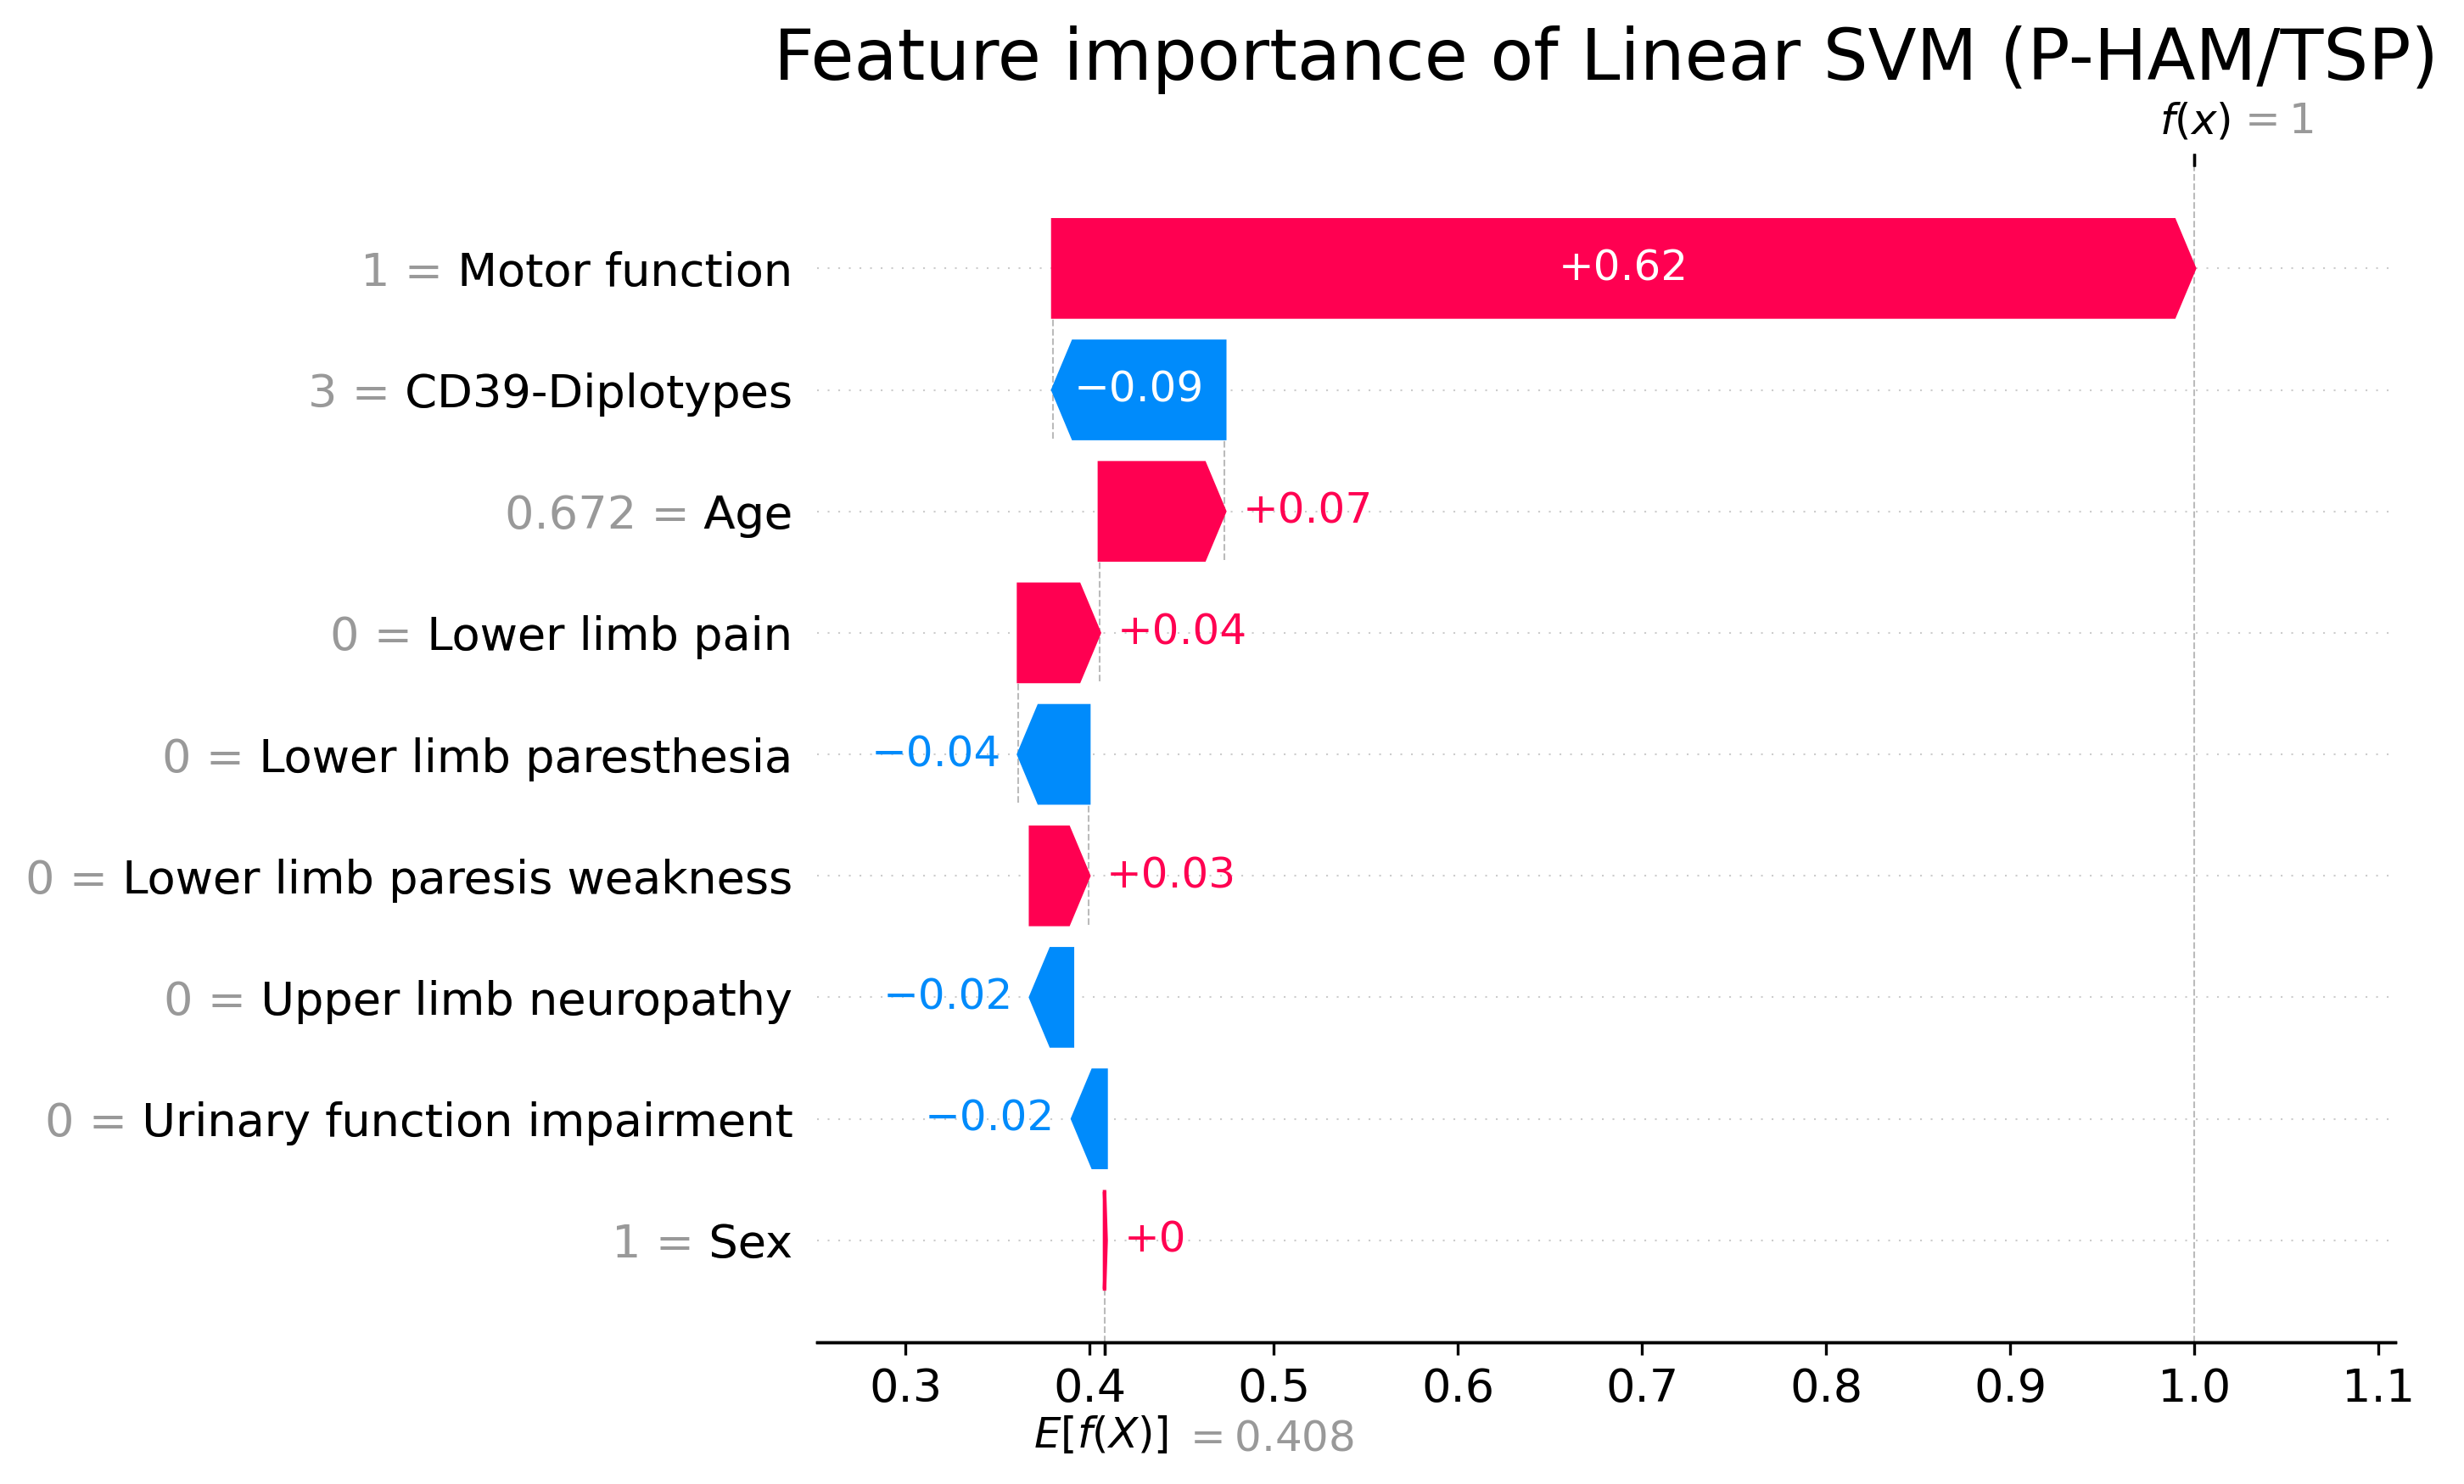

In [8]:
for model_name, item in classifiers.items():
    # Treinando o modelo
    item.fit(X, y)

    # Criando o explicador SHAP
    explainer = shap.Explainer(item.predict, X)
    shap_values = explainer(X)

    # Nome completo do modelo
    full_name = definite_name[model_names.index(model_name)]

    print(f'Importância das Características do modelo {full_name}')

    # Ajustando o tamanho do gráfico
    plt.figure(figsize=(8, 5), dpi=300)  # Reduzindo tamanho e DPI

    # Gráfico waterfall com limite de características
    shap.plots.waterfall(shap_values[55], max_display=10, show=False)

    # Adiciona título com tamanho customizado
    plt.gca().set_title(f'Feature importance of {full_name} (P-HAM/TSP)', fontsize=20)

    # Mostrar o gráfico
    plt.show()


NON-HAM/TSP

Importância das Características do modelo Decision Tree


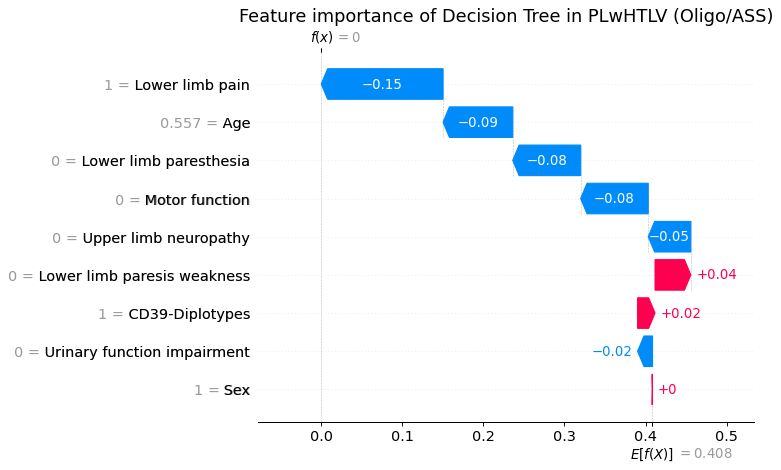

Importância das Características do modelo Gradient Boosting


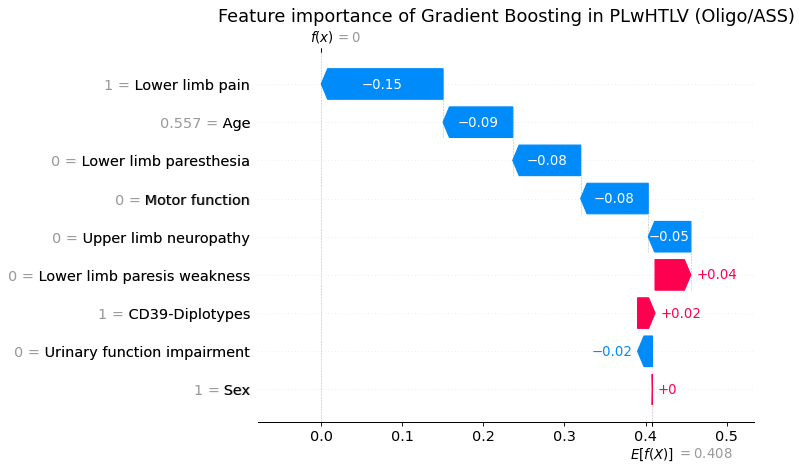

Importância das Características do modelo Logistic Regression


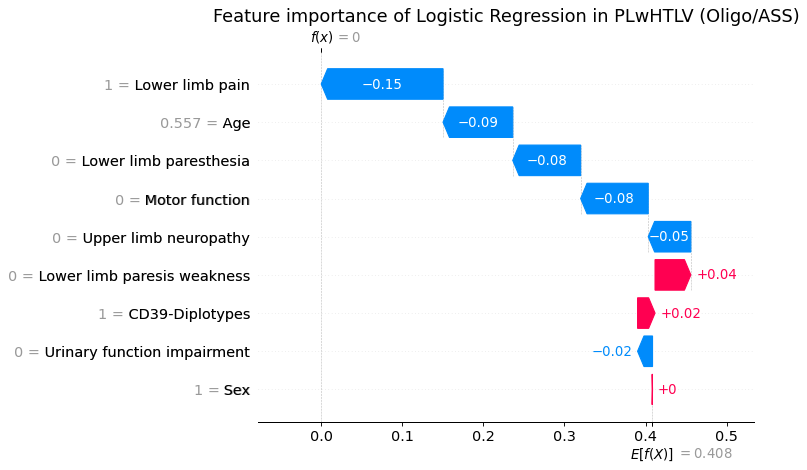

Importância das Características do modelo Multi-layer Perceptron


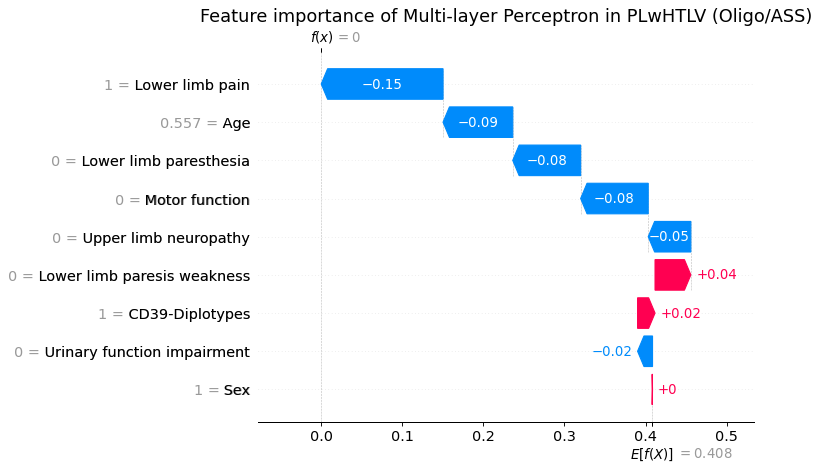

Importância das Características do modelo Naive Bayes


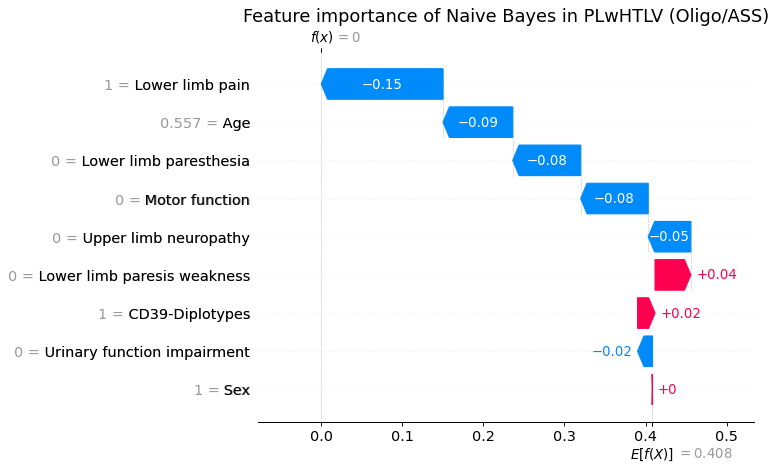

Importância das Características do modelo Random Forest


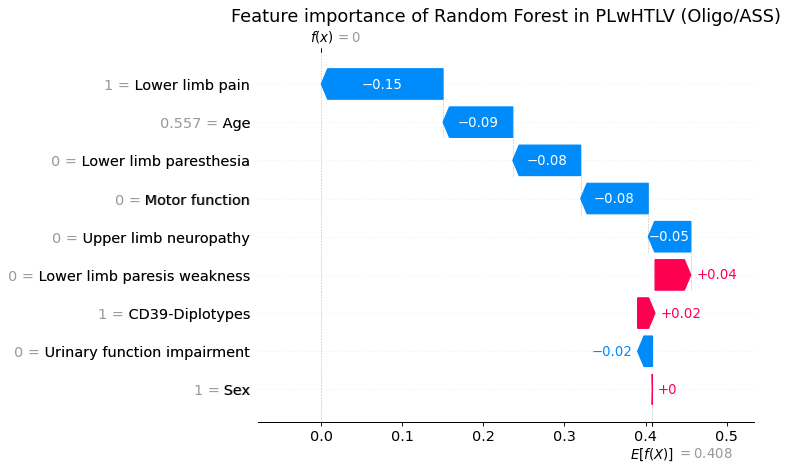

Importância das Características do modelo Support Vector Machine


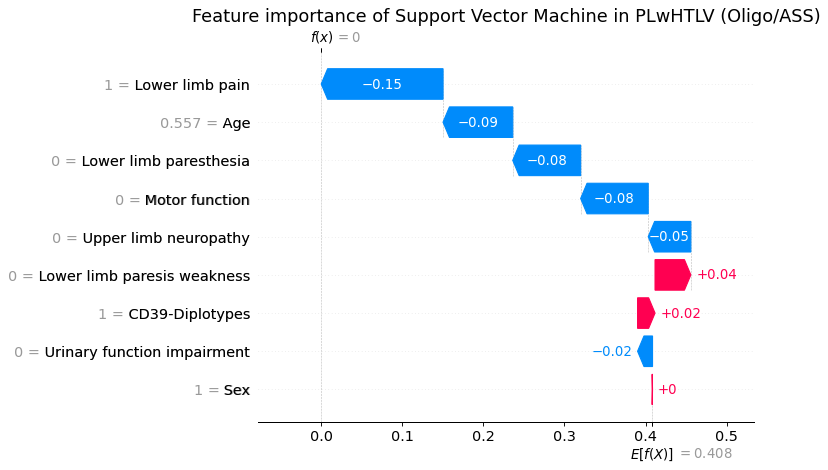

Importância das Características do modelo K-Nearest Neighbors


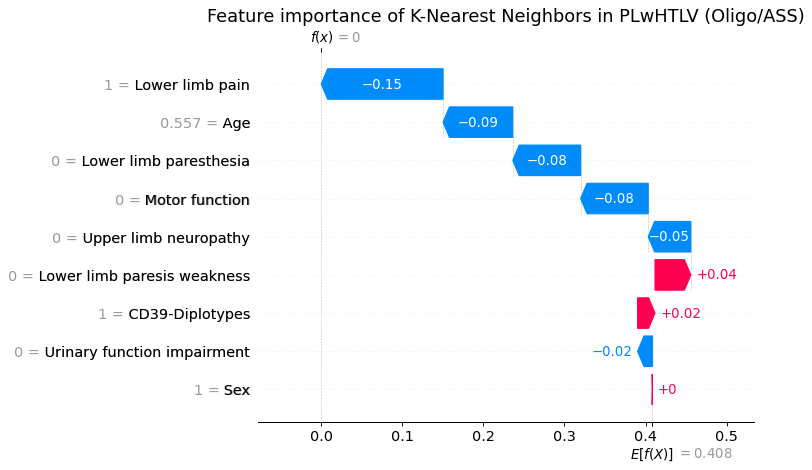

Importância das Características do modelo AdaBoost


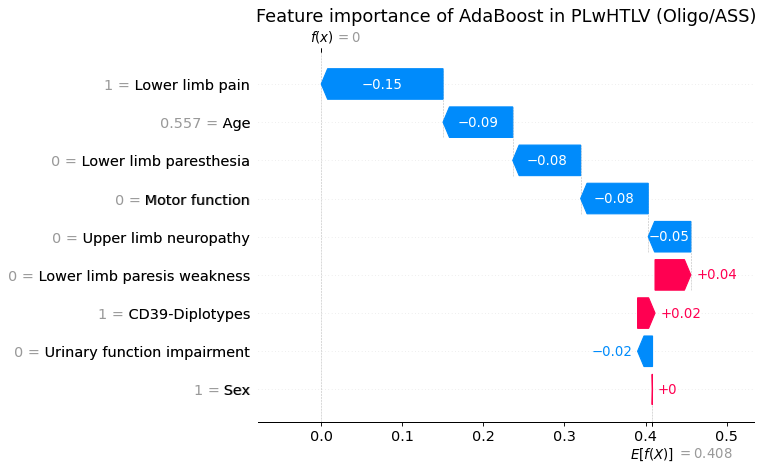

Importância das Características do modelo Linear SVM


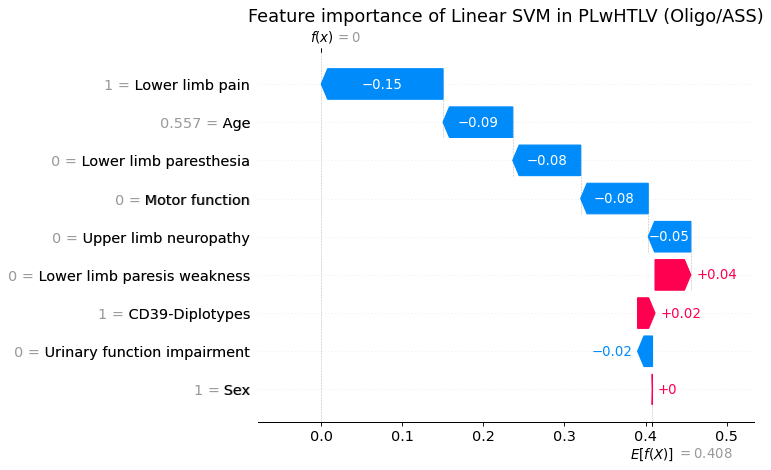

In [9]:
# Training the classifiers
for model_name, item in classifiers.items():
    # Training model
    item.fit(X, y)

    # Fits the explainer
    explainer = shap.Explainer(item.predict, X)
    # Calculates the SHAP values - It takes some time

    # Get the corresponding full name from definite_name
    full_name = definite_name[model_names.index(model_name)]

    print(f'Importância das Características do modelo {full_name}')

    # Ajustando o DPI para evitar erro de renderização
    plt.figure(figsize=(10, 6), dpi=80)  # Reduzindo o DPI da imagem

    shap.plots.waterfall(shap_values[12], show=False)

    # Adiciona título com tamanho customizado
    plt.gca().set_title(f'Feature importance of {full_name} in PLwHTLV (Oligo/ASS)', fontsize=16)

    # Mostrar o gráfico
    plt.show()
